## Part 1: Text Preprocessing and Exploration

Let's import the required libraries and load our dataset:

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# For dataset loading
from sklearn.datasets import fetch_20newsgroups

# Set random seed for reproducibility
np.random.seed(42)

# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': [newsgroups.target_names[target] for target in newsgroups.target]
})

# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


### Step 1: Basic Data Exploration
Let's examine the length characteristics of our documents:

In [2]:
# Calculate document lengths in characters and words
df['char_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Display basic statistics for document lengths
print("Document Length Statistics (Characters):")
print(df['char_length'].describe())
print("\nDocument Length Statistics (Words):")
print(df['word_count'].describe())

# Create visualizations for document length distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution
axes[0, 0].hist(df['char_length'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of Document Character Length')
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')

# Word count distribution
axes[0, 1].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Distribution of Document Word Count')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

# Character length by category
df.boxplot(column='char_length', by='category', ax=axes[1, 0])
axes[1, 0].set_title('Character Length by Category')
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Character Length')

# Word count by category
df.boxplot(column='word_count', by='category', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Category')
axes[1, 1].set_xlabel('Category')
axes[1, 1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

# Show category-wise statistics
print("\nCharacter Length by Category:")
print(df.groupby('category')['char_length'].describe())
print("\nWord Count by Category:")
print(df.groupby('category')['word_count'].describe())

Document Length Statistics (Characters):
count     2236.000000
mean      1918.330948
std       3850.168516
min        125.000000
25%        744.000000
50%       1157.500000
75%       1859.000000
max      60713.000000
Name: char_length, dtype: float64

Document Length Statistics (Words):
count    2236.000000
mean      291.903846
std       584.403700
min        15.000000
25%       104.000000
50%       173.500000
75%       290.000000
max      9168.000000
Name: word_count, dtype: float64



Character Length by Category:
                    count         mean          std    min     25%     50%  \
category                                                                     
comp.graphics       584.0  1557.083904  4684.767252  125.0   572.5   883.0   
rec.autos           594.0  1444.897306  1594.224770  131.0   754.0  1133.5   
sci.space           593.0  2016.170320  3213.495426  166.0   796.0  1195.0   
talk.politics.misc  465.0  2852.027957  5105.607017  160.0  1079.0  1644.0   

                       75%      max  
category                             
comp.graphics       1341.5  60713.0  
rec.autos           1750.5  27760.0  
sci.space           1912.0  40353.0  
talk.politics.misc  2680.0  49447.0  

Word Count by Category:
                    count        mean         std   min    25%    50%     75%  \
category                                                                        
comp.graphics       584.0  225.248288  674.097207  16.0   79.0  126.5  194.25   
rec.

### Step 2: Text Cleaning and Preprocessing Function
Let's create a comprehensive text preprocessing function that incorporates all the techniques we've learned:

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from gensim.models import Word2Vec
import emoji
from sklearn.metrics.pairwise import cosine_similarity

def text_preprocessing(texts, 
                                   mode='classification',
                                   vectorization='bow',
                                   max_features=1000,
                                   use_stemming=True,
                                   use_lemmatization=True,
                                   remove_stopwords=True,
                                   custom_stopwords=None,
                                   retain_emojis=False,
                                   apply_pca=False,
                                   pca_components=100,
                                   apply_tsne=False,
                                   tsne_components=2):
    """
    Text preprocessing function with multiple options
    
    Parameters:
    -----------
    texts : list or pd.Series
        Input texts to preprocess
    mode : str
        'classification' or 'regression' - affects output format
    vectorization : str
        'bow' for Bag of Words, 'tfidf' for TF-IDF
    max_features : int
        Maximum number of features for vectorization
    use_stemming : bool
        Whether to apply stemming
    use_lemmatization : bool
        Whether to apply lemmatization
    remove_stopwords : bool
        Whether to remove stop words
    custom_stopwords : list
        Additional stop words to remove
    retain_emojis : bool
        Whether to retain emoji characters
    apply_pca : bool
        Whether to apply PCA dimensionality reduction
    pca_components : int
        Number of PCA components
    apply_tsne : bool
        Whether to apply t-SNE
    tsne_components : int
        Number of t-SNE components
    
    Returns:
    --------
    dict containing processed data and utilities
    """
    
    
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    def clean_text(text):
        """Clean and normalize individual text"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Handle emojis
        if retain_emojis:
            # Convert emojis to text descriptions
            text = emoji.demojize(text, delimiters=(" emoji_", " "))
        else:
            # Remove emojis completely
            text = emoji.replace_emoji(text, replace='')
        
        # Remove email headers and metadata (common in newsgroups)
        text = re.sub(r'^from:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
        text = re.sub(r'^subject:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
        text = re.sub(r'^organization:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
        text = re.sub(r'^lines:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
        
        # Remove URLs and email addresses
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_process(text):
        """Tokenize and apply stemming/lemmatization"""
        if not text:
            return []
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        if remove_stopwords:
            tokens = [token for token in tokens if token not in stop_words]
        
        # Apply stemming and/or lemmatization
        processed_tokens = []
        for token in tokens:
            if len(token) > 2:  # Keep only tokens longer than 2 characters
                if use_stemming:
                    token = stemmer.stem(token)
                if use_lemmatization:
                    token = lemmatizer.lemmatize(token)
                processed_tokens.append(token)
        
        return processed_tokens
    
    print("Starting text preprocessing...")
    
    # Step 1: Clean texts
    print("1. Cleaning and normalizing texts...")
    cleaned_texts = [clean_text(text) for text in texts]
    
    # Step 2: Tokenize and process
    print("2. Tokenizing and processing tokens...")
    processed_tokens = [tokenize_and_process(text) for text in cleaned_texts]
    
    # Step 3: Create processed text strings for vectorization
    processed_text_strings = [' '.join(tokens) for tokens in processed_tokens]
    
    # Step 4: Vectorization
    print(f"3. Applying {vectorization} vectorization...")
    if vectorization == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
    else:  # bow
        vectorizer = CountVectorizer(max_features=max_features, ngram_range=(1, 2))
    
    X_vectorized = vectorizer.fit_transform(processed_text_strings)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"   Vectorized shape: {X_vectorized.shape}")
    
    # Step 5: Word2Vec embeddings (alternative representation)
    print("4. Training Word2Vec model...")
    # Filter out empty token lists
    valid_tokens = [tokens for tokens in processed_tokens if tokens]
    if valid_tokens:
        w2v_model = Word2Vec(sentences=valid_tokens, 
                           vector_size=100, 
                           window=5, 
                           min_count=2, 
                           workers=1,
                           seed=42)
        
        # Create document embeddings by averaging word vectors
        def get_doc_embedding(tokens):
            vectors = []
            for token in tokens:
                if token in w2v_model.wv:
                    vectors.append(w2v_model.wv[token])
            if vectors:
                return np.mean(vectors, axis=0)
            else:
                return np.zeros(w2v_model.vector_size)
        
        w2v_embeddings = np.array([get_doc_embedding(tokens) for tokens in processed_tokens])
        print(f"   Word2Vec embeddings shape: {w2v_embeddings.shape}")
    else:
        w2v_model = None
        w2v_embeddings = None
    
    # Step 6: Dimensionality Reduction
    X_reduced = X_vectorized.toarray()
    pca_model = None
    tsne_model = None
    
    if apply_pca and X_vectorized.shape[1] > pca_components:
        print(f"5. Applying PCA with {pca_components} components...")
        pca_model = PCA(n_components=pca_components, random_state=42)
        X_reduced = pca_model.fit_transform(X_reduced)
        print(f"   PCA shape: {X_reduced.shape}")
        print(f"   Explained variance ratio: {sum(pca_model.explained_variance_ratio_):.3f}")
    
    if apply_tsne:
        print(f"6. Applying t-SNE with {tsne_components} components...")
        # Use PCA result if available, otherwise use first 50 features for t-SNE
        tsne_input = X_reduced if apply_pca else X_vectorized.toarray()[:, :50]
        tsne_model = TSNE(n_components=tsne_components, random_state=42, perplexity=30)
        X_tsne = tsne_model.fit_transform(tsne_input)
        print(f"   t-SNE shape: {X_tsne.shape}")
    
    # Step 7: Distance and Similarity Functions
    def calculate_distances(X):
        """Calculate pairwise distances"""
        euclidean_dist = euclidean_distances(X)
        manhattan_dist = manhattan_distances(X)
        return euclidean_dist, manhattan_dist
    
    def cosine_similarity_matrix(X):
        """Calculate cosine similarity matrix"""
        return cosine_similarity(X)
    
    # Step 8: Prepare results dictionary
    results = {
        'original_texts': texts,
        'cleaned_texts': cleaned_texts,
        'processed_tokens': processed_tokens,
        'processed_text_strings': processed_text_strings,
        'vectorizer': vectorizer,
        'X_vectorized': X_vectorized,
        'X_reduced': X_reduced,
        'feature_names': feature_names,
        'w2v_model': w2v_model,
        'w2v_embeddings': w2v_embeddings,
        'pca_model': pca_model,
        'tsne_model': tsne_model,
        'distance_functions': {
            'euclidean': lambda X: euclidean_distances(X),
            'manhattan': lambda X: manhattan_distances(X),
            'cosine_similarity': cosine_similarity_matrix
        },
        'preprocessing_stats': {
            'original_count': len(texts),
            'avg_original_length': np.mean([len(str(text)) for text in texts]),
            'avg_cleaned_length': np.mean([len(text) for text in cleaned_texts]),
            'avg_tokens_per_doc': np.mean([len(tokens) for tokens in processed_tokens]),
            'vocabulary_size': len(vectorizer.vocabulary_),
            'total_features': X_vectorized.shape[1]
        }
    }
    
    # Add t-SNE results if computed
    if apply_tsne:
        results['X_tsne'] = X_tsne
    
    print("\nPreprocessing completed!")
    print(f"Final feature matrix shape: {X_reduced.shape}")
    print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"Average tokens per document: {results['preprocessing_stats']['avg_tokens_per_doc']:.1f}")
    
    return results

# Example usage with our dataset
print("Applying preprocessing to newsgroups dataset...")
preprocessed_data = text_preprocessing(
    texts=df['text'].head(100),  # Use first 100 documents for demo
    mode='classification',
    vectorization='tfidf',
    max_features=500,
    use_stemming=True,
    use_lemmatization=True,
    remove_stopwords=True,
    retain_emojis=False,
    apply_pca=True,
    pca_components=50,
    apply_tsne=True,
    tsne_components=2
)

# Display preprocessing statistics
print("\n" + "="*50)
print("PREPROCESSING STATISTICS:")
print("="*50)
for key, value in preprocessed_data['preprocessing_stats'].items():
    print(f"{key}: {value}")

# Show sample processed text
print("\n" + "="*50)
print("SAMPLE PROCESSED TEXT:")
print("="*50)
print("Original:", preprocessed_data['original_texts'][0][:200] + "...")
print("Cleaned:", preprocessed_data['cleaned_texts'][0][:200] + "...")
print("Tokens:", preprocessed_data['processed_tokens'][0][:20])

Applying preprocessing to newsgroups dataset...
Starting text preprocessing...
1. Cleaning and normalizing texts...
2. Tokenizing and processing tokens...
2. Tokenizing and processing tokens...
3. Applying tfidf vectorization...
   Vectorized shape: (100, 500)
4. Training Word2Vec model...
   Word2Vec embeddings shape: (100, 100)
5. Applying PCA with 50 components...
   PCA shape: (100, 50)
   Explained variance ratio: 0.709
6. Applying t-SNE with 2 components...
3. Applying tfidf vectorization...
   Vectorized shape: (100, 500)
4. Training Word2Vec model...
   Word2Vec embeddings shape: (100, 100)
5. Applying PCA with 50 components...
   PCA shape: (100, 50)
   Explained variance ratio: 0.709
6. Applying t-SNE with 2 components...
   t-SNE shape: (100, 2)

Preprocessing completed!
Final feature matrix shape: (100, 50)
Vocabulary size: 500
Average tokens per document: 104.1

PREPROCESSING STATISTICS:
original_count: 100
avg_original_length: 1472.63
avg_cleaned_length: 1082.61
avg_token

### Step 3: Apply Preprocessing and Analyze Results
Now let's apply our preprocessing function to the dataset and examine the results:

Applying preprocessing to the full newsgroups dataset...
Starting text preprocessing...
1. Cleaning and normalizing texts...
2. Tokenizing and processing tokens...
2. Tokenizing and processing tokens...
3. Applying tfidf vectorization...
3. Applying tfidf vectorization...
   Vectorized shape: (2236, 1000)
4. Training Word2Vec model...
   Vectorized shape: (2236, 1000)
4. Training Word2Vec model...
   Word2Vec embeddings shape: (2236, 100)
5. Applying PCA with 100 components...
   Word2Vec embeddings shape: (2236, 100)
5. Applying PCA with 100 components...
   PCA shape: (2236, 100)
   Explained variance ratio: 0.379

Preprocessing completed!
Final feature matrix shape: (2236, 100)
Vocabulary size: 1000
Average tokens per document: 138.0

PREPROCESSING ANALYSIS

1. PREPROCESSING IMPACT:
------------------------------
Original documents: 2236
Average original length: 1918.3 characters
Average cleaned length: 1454.8 characters
Length reduction: 24.2%
Average tokens per document: 138.0
Voc

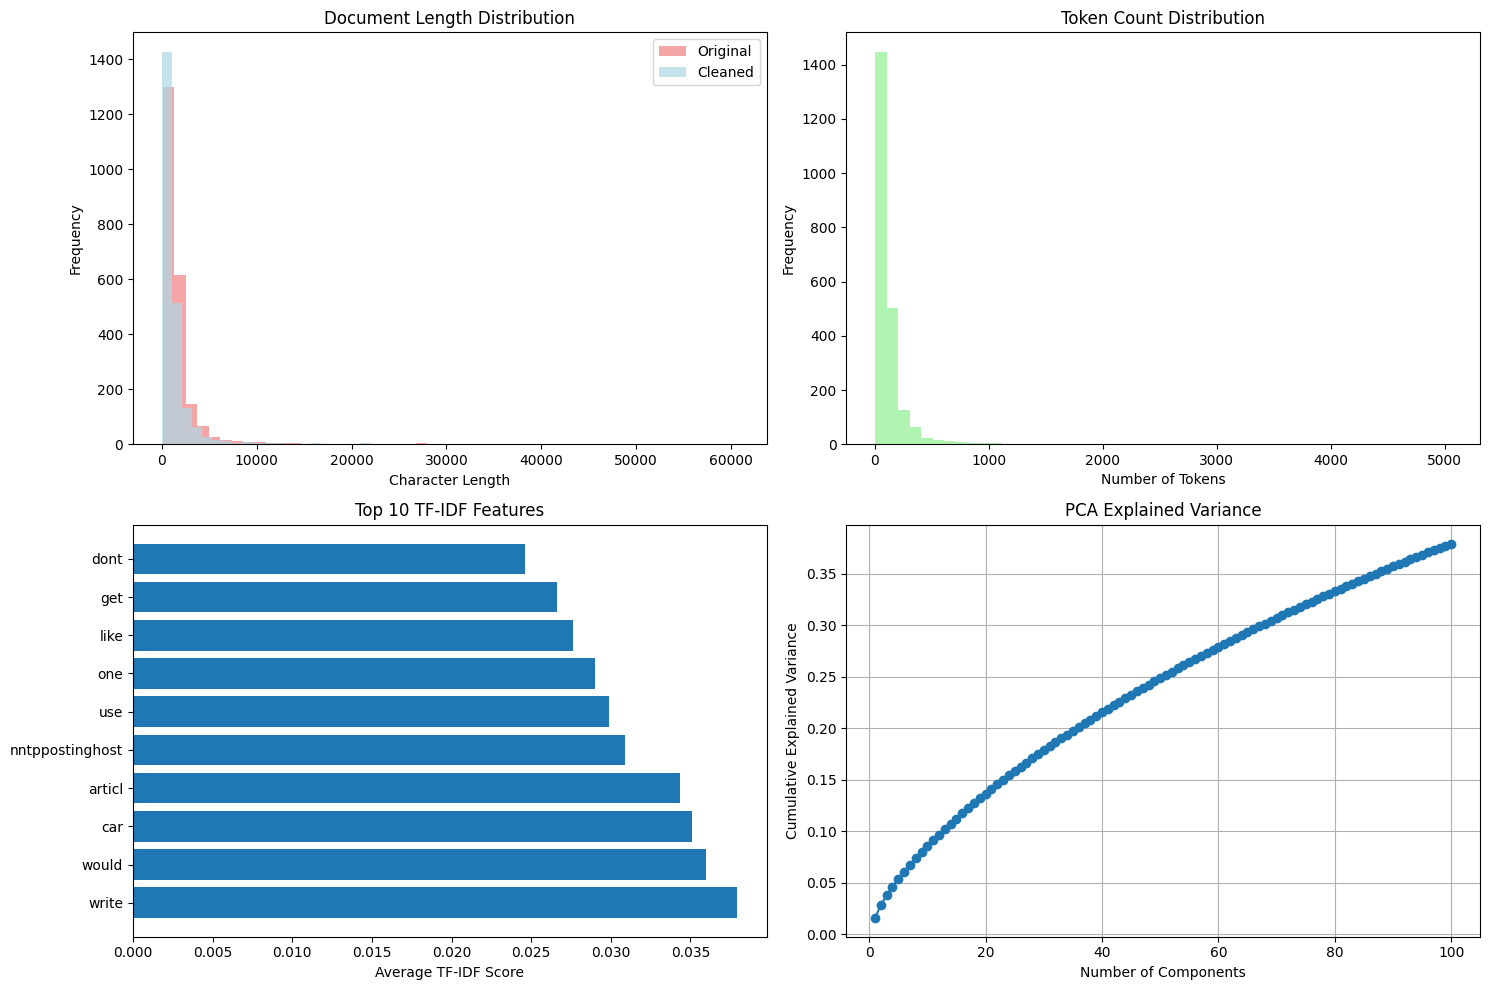


6. WORD2VEC MODEL ANALYSIS:
------------------------------
Vocabulary size: 12305
Vector dimensions: 100
Words similar to 'computer': ['sgi', 'flexibl', 'storag']
Words similar to 'car': ['overtak', 'dealer', 'buy']
Words similar to 'space': ['nasa', 'denver', 'scienc']
Words similar to 'government': ['adequ', 'cruis', 'degrad']

PREPROCESSING COMPLETED SUCCESSFULLY!


In [4]:
# Apply preprocessing to the full dataset
print("Applying preprocessing to the full newsgroups dataset...")
full_preprocessed_data = text_preprocessing(
    texts=df['text'],
    mode='classification',
    vectorization='tfidf',
    max_features=1000,
    use_stemming=True,
    use_lemmatization=True,
    remove_stopwords=True,
    retain_emojis=False,
    apply_pca=True,
    pca_components=100,
    apply_tsne=False  # Skip t-SNE for full dataset due to computational cost
)

# Create analysis of the preprocessing results
print("\n" + "="*60)
print("PREPROCESSING ANALYSIS")
print("="*60)

# 1. Basic statistics comparison
print("\n1. PREPROCESSING IMPACT:")
print("-" * 30)
stats = full_preprocessed_data['preprocessing_stats']
print(f"Original documents: {stats['original_count']}")
print(f"Average original length: {stats['avg_original_length']:.1f} characters")
print(f"Average cleaned length: {stats['avg_cleaned_length']:.1f} characters")
print(f"Length reduction: {((stats['avg_original_length'] - stats['avg_cleaned_length']) / stats['avg_original_length'] * 100):.1f}%")
print(f"Average tokens per document: {stats['avg_tokens_per_doc']:.1f}")
print(f"Vocabulary size: {stats['vocabulary_size']}")
print(f"Feature matrix shape: {full_preprocessed_data['X_vectorized'].shape}")
print(f"PCA reduced shape: {full_preprocessed_data['X_reduced'].shape}")

# 2. Category analysis
print("\n2. CATEGORY TOKEN ANALYSIS:")
print("-" * 30)
# Calculate tokens per category
df_temp = df.copy()
df_temp['processed_tokens'] = full_preprocessed_data['processed_tokens']
df_temp['token_count'] = df_temp['processed_tokens'].apply(len)

category_stats = df_temp.groupby('category')['token_count'].agg(['mean', 'std', 'min', 'max']).round(1)
print(category_stats)

# 3. Top features analysis
print("\n3. TOP TF-IDF FEATURES:")
print("-" * 30)
# Get feature importance across all documents
X_dense = full_preprocessed_data['X_vectorized'].toarray()
feature_importance = X_dense.mean(axis=0)
feature_names = full_preprocessed_data['feature_names']

# Get top 20 features
top_indices = feature_importance.argsort()[-20:][::-1]
print("Most important features (by average TF-IDF score):")
for i, idx in enumerate(top_indices[:10]):
    print(f"{i+1:2d}. {feature_names[idx]:15s} ({feature_importance[idx]:.4f})")

# 4. Sample comparison
print("\n4. SAMPLE TEXT COMPARISON:")
print("-" * 30)
sample_idx = 5
print("Original text (first 300 chars):")
print(full_preprocessed_data['original_texts'][sample_idx][:300] + "...")
print("\nCleaned text (first 300 chars):")
print(full_preprocessed_data['cleaned_texts'][sample_idx][:300] + "...")
print(f"\nProcessed tokens (first 20): {full_preprocessed_data['processed_tokens'][sample_idx][:20]}")

# 5. Visualization of preprocessing impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length before and after
axes[0, 0].hist([len(text) for text in full_preprocessed_data['original_texts']], 
                bins=50, alpha=0.7, label='Original', color='lightcoral')
axes[0, 0].hist([len(text) for text in full_preprocessed_data['cleaned_texts']], 
                bins=50, alpha=0.7, label='Cleaned', color='lightblue')
axes[0, 0].set_title('Document Length Distribution')
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Token count distribution
token_counts = [len(tokens) for tokens in full_preprocessed_data['processed_tokens']]
axes[0, 1].hist(token_counts, bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Token Count Distribution')
axes[0, 1].set_xlabel('Number of Tokens')
axes[0, 1].set_ylabel('Frequency')

# Top features visualization
top_10_features = feature_names[top_indices[:10]]
top_10_scores = feature_importance[top_indices[:10]]
axes[1, 0].barh(range(len(top_10_features)), top_10_scores)
axes[1, 0].set_yticks(range(len(top_10_features)))
axes[1, 0].set_yticklabels(top_10_features)
axes[1, 0].set_xlabel('Average TF-IDF Score')
axes[1, 0].set_title('Top 10 TF-IDF Features')

# PCA explained variance
if full_preprocessed_data['pca_model'] is not None:
    cumsum_var = np.cumsum(full_preprocessed_data['pca_model'].explained_variance_ratio_)
    axes[1, 1].plot(range(1, len(cumsum_var) + 1), cumsum_var, marker='o')
    axes[1, 1].set_xlabel('Number of Components')
    axes[1, 1].set_ylabel('Cumulative Explained Variance')
    axes[1, 1].set_title('PCA Explained Variance')
    axes[1, 1].grid(True)
    print(f"\n5. PCA ANALYSIS:")
    print("-" * 30)
    print(f"Explained variance by first 10 components: {cumsum_var[9]:.3f}")
    print(f"Explained variance by all 100 components: {cumsum_var[-1]:.3f}")

plt.tight_layout()
plt.show()

# 6. Word2Vec analysis
if full_preprocessed_data['w2v_model'] is not None:
    print("\n6. WORD2VEC MODEL ANALYSIS:")
    print("-" * 30)
    w2v_model = full_preprocessed_data['w2v_model']
    print(f"Vocabulary size: {len(w2v_model.wv)}")
    print(f"Vector dimensions: {w2v_model.vector_size}")
    
    # Find similar words for some key terms
    test_words = ['computer', 'car', 'space', 'government']
    for word in test_words:
        if word in w2v_model.wv:
            similar_words = w2v_model.wv.most_similar(word, topn=3)
            print(f"Words similar to '{word}': {[w[0] for w in similar_words]}")

print("\n" + "="*60)
print("PREPROCESSING COMPLETED SUCCESSFULLY!")
print("="*60)

### Step 4: Token Frequency Analysis
Let's analyze the most common words in each category after preprocessing:

In [5]:
from collections import Counter

# Token frequency analysis for each category
print("ANALYZING TOKEN FREQUENCIES BY CATEGORY")
print("="*60)

# Create a temporary DataFrame with category information and processed tokens
df_analysis = df.copy()
df_analysis['processed_tokens'] = full_preprocessed_data['processed_tokens']
df_analysis['token_count'] = df_analysis['processed_tokens'].apply(len)

# Function to get top tokens for a category
def get_top_tokens_for_category(category, top_n=20):
    """Get most frequent tokens for a specific category"""
    # Filter documents for this category
    category_docs = df_analysis[df_analysis['category'] == category]
    
    # Combine all tokens from this category
    all_tokens = []
    for tokens in category_docs['processed_tokens']:
        all_tokens.extend(tokens)
    
    # Count token frequencies
    token_counter = Counter(all_tokens)
    
    return token_counter.most_common(top_n)

# Analyze each category
categories = df['category'].unique()
category_token_analysis = {}

for category in categories:
    print(f"\n{category.upper()}")
    print("-" * 40)
    
    # Get category statistics
    category_docs = df_analysis[df_analysis['category'] == category]
    print(f"Number of documents: {len(category_docs)}")
    print(f"Average tokens per document: {category_docs['token_count'].mean():.1f}")
    print(f"Total tokens: {category_docs['token_count'].sum()}")
    
    # Get top tokens
    top_tokens = get_top_tokens_for_category(category, top_n=20)
    category_token_analysis[category] = top_tokens
    
    print(f"\nTop 20 most frequent tokens:")
    for i, (token, freq) in enumerate(top_tokens, 1):
        print(f"{i:2d}. {token:15s} ({freq:4d})")

# Create visualization of top tokens by category
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, category in enumerate(categories):
    top_tokens = category_token_analysis[category][:10]  # Top 10 for visualization
    tokens = [item[0] for item in top_tokens]
    frequencies = [item[1] for item in top_tokens]
    
    axes[idx].barh(range(len(tokens)), frequencies)
    axes[idx].set_yticks(range(len(tokens)))
    axes[idx].set_yticklabels(tokens)
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_title(f'Top 10 Tokens: {category}')
    axes[idx].invert_yaxis()  # Show highest frequency at top

plt.tight_layout()
plt.show()

# Compare unique tokens across categories
print("\n" + "="*60)
print("CATEGORY COMPARISON ANALYSIS")
print("="*60)

# Find category-specific tokens (tokens that appear much more in one category)
def analyze_category_specific_tokens(min_frequency=10, ratio_threshold=3.0):
    """Find tokens that are characteristic of specific categories"""
    
    # Get all unique tokens
    all_tokens = set()
    for tokens in full_preprocessed_data['processed_tokens']:
        all_tokens.update(tokens)
    
    category_specific = {}
    
    for category in categories:
        category_specific[category] = []
        category_docs = df_analysis[df_analysis['category'] == category]
        other_docs = df_analysis[df_analysis['category'] != category]
        
        # Get token counts for this category and others
        category_tokens = []
        for tokens in category_docs['processed_tokens']:
            category_tokens.extend(tokens)
        category_counter = Counter(category_tokens)
        
        other_tokens = []
        for tokens in other_docs['processed_tokens']:
            other_tokens.extend(tokens)
        other_counter = Counter(other_tokens)
        
        # Find tokens that are much more frequent in this category
        for token in category_counter:
            cat_freq = category_counter[token]
            other_freq = other_counter.get(token, 0)
            
            if cat_freq >= min_frequency and other_freq > 0:
                ratio = cat_freq / (other_freq / len(other_docs) * len(category_docs))
                if ratio >= ratio_threshold:
                    category_specific[category].append((token, cat_freq, ratio))
        
        # Sort by ratio (most characteristic first)
        category_specific[category].sort(key=lambda x: x[2], reverse=True)
    
    return category_specific

category_specific_tokens = analyze_category_specific_tokens()

print("\nCATEGORY-SPECIFIC TOKENS (most characteristic):")
print("-" * 50)
for category in categories:
    print(f"\n{category.upper()}:")
    specific_tokens = category_specific_tokens[category][:10]  # Top 10
    if specific_tokens:
        for i, (token, freq, ratio) in enumerate(specific_tokens, 1):
            print(f"{i:2d}. {token:15s} (freq: {freq:3d}, ratio: {ratio:.1f}x)")
    else:
        print("    No highly characteristic tokens found")

# Create a cross-category token comparison matrix
print("\n" + "="*60)
print("TOKEN OVERLAP ANALYSIS")
print("="*60)

# Calculate token overlap between categories
overlap_matrix = pd.DataFrame(index=categories, columns=categories)

for cat1 in categories:
    tokens1 = set()
    for tokens in df_analysis[df_analysis['category'] == cat1]['processed_tokens']:
        tokens1.update(tokens)
    
    for cat2 in categories:
        tokens2 = set()
        for tokens in df_analysis[df_analysis['category'] == cat2]['processed_tokens']:
            tokens2.update(tokens)
        
        if cat1 == cat2:
            overlap_matrix.loc[cat1, cat2] = len(tokens1)
        else:
            intersection = len(tokens1.intersection(tokens2))
            union = len(tokens1.union(tokens2))
            jaccard_similarity = intersection / union if union > 0 else 0
            overlap_matrix.loc[cat1, cat2] = jaccard_similarity

print("\nToken Overlap Matrix (Jaccard Similarity):")
print("Diagonal shows unique vocabulary size per category")
print(overlap_matrix.round(3))

# Visualize the overlap matrix
plt.figure(figsize=(10, 8))
# Convert diagonal to show vocabulary sizes, off-diagonal shows similarities
overlap_viz = overlap_matrix.astype(float)
for i, cat in enumerate(categories):
    overlap_viz.iloc[i, i] = len(set([token for tokens in df_analysis[df_analysis['category'] == cat]['processed_tokens'] for token in tokens]))

# Create two separate plots: one for similarities, one for vocabulary sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Similarity heatmap (excluding diagonal)
sim_matrix = overlap_matrix.astype(float).copy()
np.fill_diagonal(sim_matrix.values, np.nan)
sns.heatmap(sim_matrix, annot=True, cmap='Blues', ax=ax1, cbar_kws={'label': 'Jaccard Similarity'})
ax1.set_title('Token Similarity Between Categories')
ax1.set_xlabel('Category')
ax1.set_ylabel('Category')

# Vocabulary size bar plot
vocab_sizes = [len(set([token for tokens in df_analysis[df_analysis['category'] == cat]['processed_tokens'] for token in tokens])) for cat in categories]
ax2.bar(range(len(categories)), vocab_sizes, color='lightblue')
ax2.set_xticks(range(len(categories)))
ax2.set_xticklabels(categories, rotation=45)
ax2.set_ylabel('Unique Vocabulary Size')
ax2.set_title('Vocabulary Size by Category')

plt.tight_layout()
plt.show()

print(f"\nSUMMARY:")
print(f"Average vocabulary similarity between categories: {np.nanmean(sim_matrix.values):.3f}")
print(f"Most similar categories: {categories[np.unravel_index(np.nanargmax(sim_matrix.values), sim_matrix.shape)[0]]} & {categories[np.unravel_index(np.nanargmax(sim_matrix.values), sim_matrix.shape)[1]]}")
print(f"Largest vocabulary: {categories[np.argmax(vocab_sizes)]} ({max(vocab_sizes)} unique tokens)")
print(f"Smallest vocabulary: {categories[np.argmin(vocab_sizes)]} ({min(vocab_sizes)} unique tokens)")

ANALYZING TOKEN FREQUENCIES BY CATEGORY

COMP.GRAPHICS
----------------------------------------
Number of documents: 584
Average tokens per document: 108.0
Total tokens: 63075

Top 20 most frequent tokens:
 1. imag            ( 763)
 2. use             ( 605)
 3. file            ( 531)
 4. graphic         ( 405)
 5. program         ( 386)
 6. write           ( 347)
 7. would           ( 295)
 8. nntppostinghost ( 272)
 9. one             ( 269)
10. format          ( 268)
11. also            ( 263)
12. know            ( 255)
13. system          ( 249)
14. get             ( 245)
15. color           ( 244)
16. jpeg            ( 244)
17. version         ( 242)
18. articl          ( 235)
19. bit             ( 231)
20. like            ( 230)

TALK.POLITICS.MISC
----------------------------------------
Number of documents: 465
Average tokens per document: 206.6
Total tokens: 96052

Top 20 most frequent tokens:
 1. would           ( 692)
 2. peopl           ( 684)
 3. write           ( 638)
 4


CATEGORY COMPARISON ANALYSIS

CATEGORY-SPECIFIC TOKENS (most characteristic):
--------------------------------------------------

COMP.GRAPHICS:
 1. jpeg            (freq: 244, ratio: 345.1x)
 2. vga             (freq:  69, ratio: 195.2x)
 3. amiga           (freq:  59, ratio: 166.9x)
 4. render          (freq:  81, ratio: 114.6x)
 5. quantiz         (freq:  38, ratio: 107.5x)
 6. postscript      (freq:  71, ratio: 100.4x)
 7. graphic         (freq: 405, ratio: 95.5x)
 8. fractal         (freq:  32, ratio: 90.5x)
 9. compgraph       (freq:  30, ratio: 84.9x)
10. int             (freq:  30, ratio: 84.9x)

TALK.POLITICS.MISC:
 1. clayton         (freq: 107, ratio: 407.5x)
 2. republican      (freq:  90, ratio: 342.8x)
 3. democrat        (freq:  77, ratio: 293.3x)
 4. hitler          (freq:  62, ratio: 236.1x)
 5. stimulu         (freq:  53, ratio: 201.9x)
 6. secretari       (freq:  94, ratio: 179.0x)
 7. promiscu        (freq:  44, ratio: 167.6x)
 8. libertarian     (freq: 127, ratio:

<Figure size 1000x800 with 0 Axes>


SUMMARY:
Average vocabulary similarity between categories: 0.242
Most similar categories: talk.politics.misc & sci.space
Largest vocabulary: sci.space (9943 unique tokens)
Smallest vocabulary: rec.autos (7340 unique tokens)


### Step 5: N-gram Analysis
Let's go beyond single words and look at common bigrams and trigrams:

N-GRAM ANALYSIS

BIGRAM ANALYSIS (2-grams)

COMP.GRAPHICS - Top 15 2-grams:
--------------------------------------------------
 1. distribut world           ( 69)
 2. imag process              ( 56)
 3. xnewsread tin             ( 52)
 4. would like                ( 51)
 5. anyon know                ( 49)
 6. comput graphic            ( 48)
 7. world nntppostinghost     ( 47)
 8. thank advanc              ( 46)
 9. file format               ( 44)
10. dont know                 ( 43)
11. tin version               ( 40)
12. write articl              ( 38)
13. sourc code                ( 37)
14. anonym ftp                ( 33)
15. ftp site                  ( 31)

TALK.POLITICS.MISC - Top 15 2-grams:
--------------------------------------------------
 1. write articl              (189)
 2. unit state                ( 97)
 3. health care               ( 97)
 4. dont know                 ( 96)
 5. clayton cramer            ( 82)
 6. dont think                ( 66)
 7. white hous              

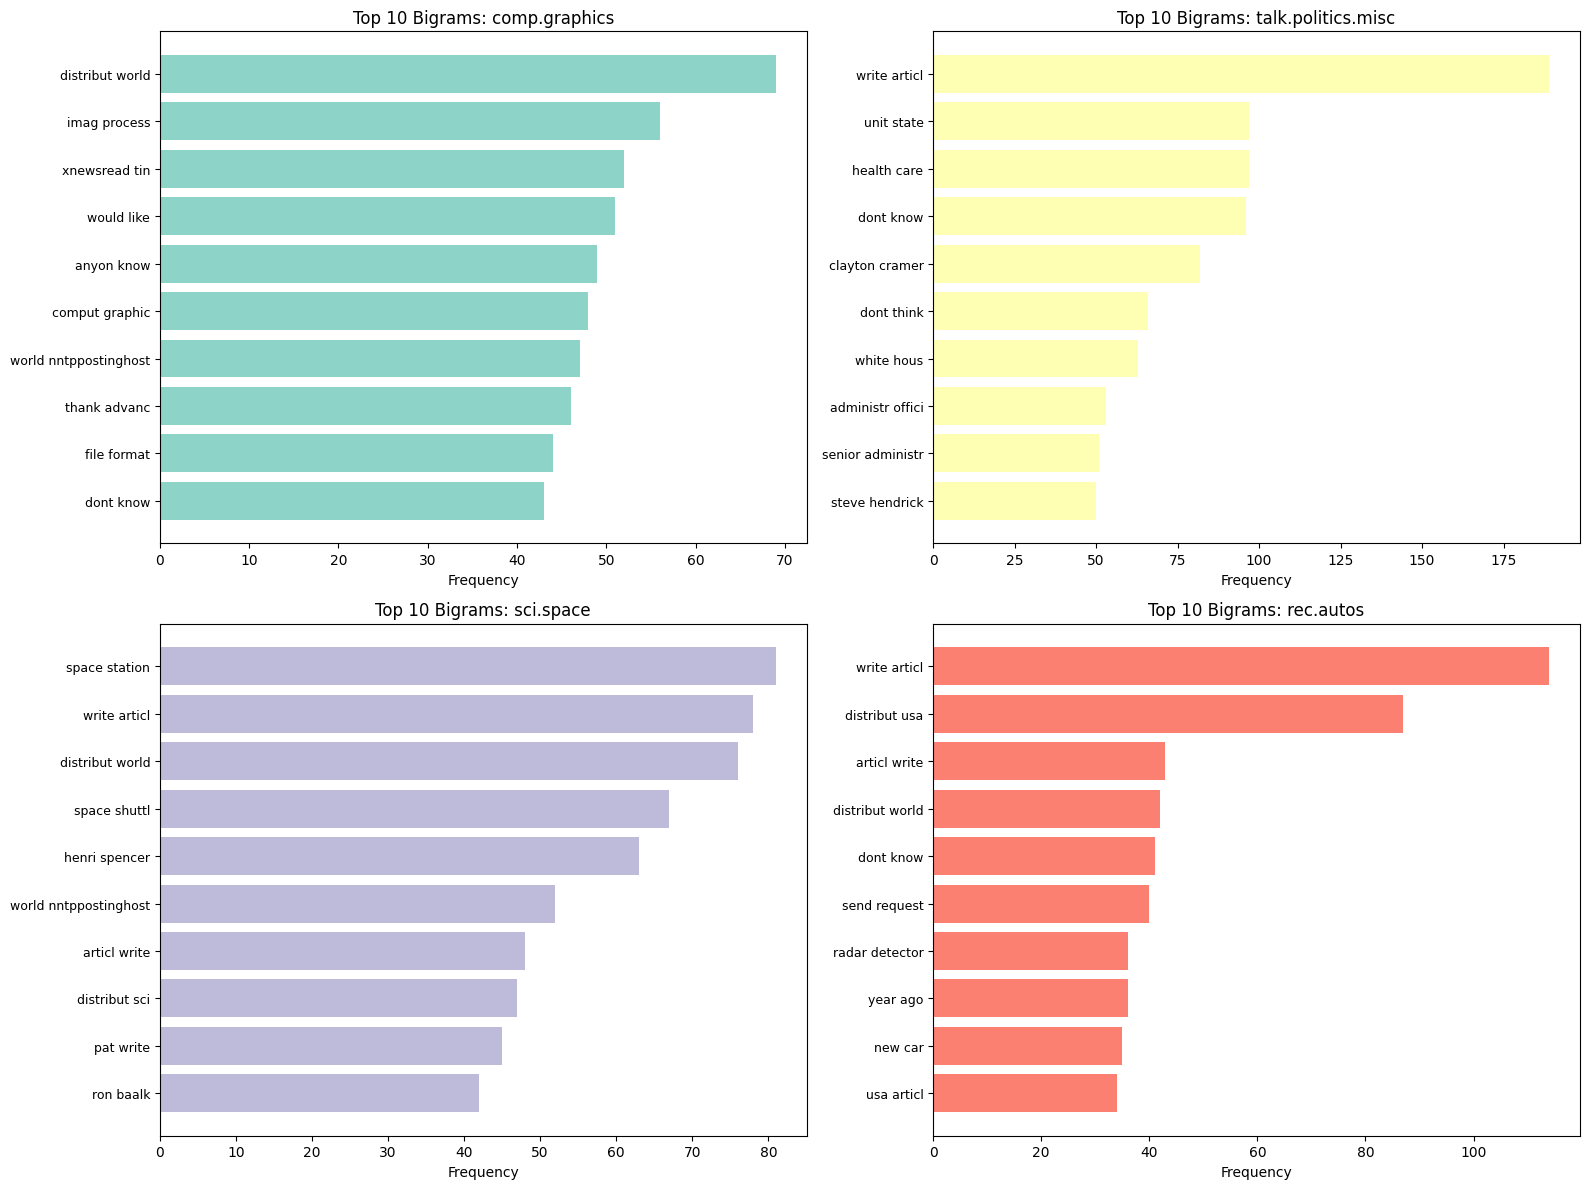


CROSS-CATEGORY N-GRAM ANALYSIS

MOST DISTINCTIVE BIGRAMS BY CATEGORY:
--------------------------------------------------

COMP.GRAPHICS:
1. imag process         (freq: 56, ratio: ∞)
2. xnewsread tin        (freq: 52, ratio: ∞)
3. comput graphic       (freq: 48, ratio: ∞)
4. thank advanc         (freq: 46, ratio: ∞)
5. file format          (freq: 44, ratio: ∞)
6. tin version          (freq: 40, ratio: ∞)
7. sourc code           (freq: 37, ratio: ∞)
8. ftp site             (freq: 31, ratio: ∞)

TALK.POLITICS.MISC:
1. unit state           (freq: 97, ratio: ∞)
2. health care          (freq: 97, ratio: ∞)
3. clayton cramer       (freq: 82, ratio: ∞)
4. dont think           (freq: 66, ratio: ∞)
5. white hous           (freq: 63, ratio: ∞)
6. administr offici     (freq: 53, ratio: ∞)
7. senior administr     (freq: 51, ratio: ∞)
8. steve hendrick       (freq: 50, ratio: ∞)

SCI.SPACE:
1. space station        (freq: 81, ratio: ∞)
2. space shuttl         (freq: 67, ratio: ∞)
3. henri spencer   


N-GRAM ANALYSIS COMPLETED!
Found 60 unique bigrams
Found 40 unique trigrams


In [6]:
# N-gram Analysis - Extract and analyze bigrams and trigrams
print("N-GRAM ANALYSIS")
print("="*60)

# Function to extract n-grams from processed tokens
def extract_ngrams(tokens_list, n=2):
    """Extract n-grams from a list of token lists"""
    all_ngrams = []
    for tokens in tokens_list:
        if len(tokens) >= n:
            ngrams_in_doc = list(ngrams(tokens, n))
            all_ngrams.extend(ngrams_in_doc)
    return all_ngrams

# Function to get top n-grams for each category
def analyze_ngrams_by_category(n=2, top_k=15):
    """Analyze n-grams for each category"""
    category_ngrams = {}
    
    for category in categories:
        print(f"\n{category.upper()} - Top {top_k} {n}-grams:")
        print("-" * 50)
        
        # Get documents for this category
        category_docs = df_analysis[df_analysis['category'] == category]
        category_tokens = category_docs['processed_tokens'].tolist()
        
        # Extract n-grams
        category_ngrams_list = extract_ngrams(category_tokens, n)
        
        # Count n-gram frequencies
        ngram_counter = Counter(category_ngrams_list)
        top_ngrams = ngram_counter.most_common(top_k)
        category_ngrams[category] = top_ngrams
        
        # Display results
        for i, (ngram, freq) in enumerate(top_ngrams, 1):
            ngram_str = ' '.join(ngram)
            print(f"{i:2d}. {ngram_str:25s} ({freq:3d})")
    
    return category_ngrams

# Analyze bigrams (2-grams)
print("\nBIGRAM ANALYSIS (2-grams)")
print("="*60)
bigrams_by_category = analyze_ngrams_by_category(n=2, top_k=15)

# Analyze trigrams (3-grams)  
print("\n\nTRIGRAM ANALYSIS (3-grams)")
print("="*60)
trigrams_by_category = analyze_ngrams_by_category(n=3, top_k=10)

# Visualize top bigrams for each category
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, category in enumerate(categories):
    top_bigrams = bigrams_by_category[category][:10]  # Top 10 for visualization
    bigram_labels = [' '.join(bigram[0]) for bigram in top_bigrams]
    frequencies = [bigram[1] for bigram in top_bigrams]
    
    axes[idx].barh(range(len(bigram_labels)), frequencies, color=plt.cm.Set3(idx))
    axes[idx].set_yticks(range(len(bigram_labels)))
    axes[idx].set_yticklabels(bigram_labels, fontsize=9)
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_title(f'Top 10 Bigrams: {category}')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

# Cross-category n-gram comparison
print("\n" + "="*60)
print("CROSS-CATEGORY N-GRAM ANALYSIS")
print("="*60)

# Find category-distinctive n-grams
def find_distinctive_ngrams(ngrams_dict, min_freq=5, top_k=5):
    """Find n-grams that are distinctive to each category"""
    distinctive_ngrams = {}
    
    for category in categories:
        distinctive_ngrams[category] = []
        category_ngrams = dict(ngrams_dict[category])
        
        # Get all other categories' n-grams
        other_ngrams = {}
        for other_cat in categories:
            if other_cat != category:
                for ngram, freq in ngrams_dict[other_cat]:
                    other_ngrams[ngram] = other_ngrams.get(ngram, 0) + freq
        
        # Find distinctive n-grams (high in this category, low in others)
        for ngram, freq in ngrams_dict[category]:
            if freq >= min_freq:
                other_freq = other_ngrams.get(ngram, 0)
                if other_freq == 0:
                    ratio = float('inf')
                else:
                    ratio = freq / other_freq
                
                if ratio > 2.0:  # At least 2x more frequent in this category
                    distinctive_ngrams[category].append((ngram, freq, ratio))
        
        # Sort by ratio (most distinctive first)
        distinctive_ngrams[category].sort(key=lambda x: x[2], reverse=True)
        distinctive_ngrams[category] = distinctive_ngrams[category][:top_k]
    
    return distinctive_ngrams

# Find distinctive bigrams
distinctive_bigrams = find_distinctive_ngrams(bigrams_by_category, min_freq=5, top_k=8)

print("\nMOST DISTINCTIVE BIGRAMS BY CATEGORY:")
print("-" * 50)
for category in categories:
    print(f"\n{category.upper()}:")
    if distinctive_bigrams[category]:
        for i, (ngram, freq, ratio) in enumerate(distinctive_bigrams[category], 1):
            ngram_str = ' '.join(ngram)
            ratio_str = "∞" if ratio == float('inf') else f"{ratio:.1f}x"
            print(f"{i}. {ngram_str:20s} (freq: {freq:2d}, ratio: {ratio_str})")
    else:
        print("   No highly distinctive bigrams found")

# Find distinctive trigrams
distinctive_trigrams = find_distinctive_ngrams(trigrams_by_category, min_freq=3, top_k=5)

print("\nMOST DISTINCTIVE TRIGRAMS BY CATEGORY:")
print("-" * 50)
for category in categories:
    print(f"\n{category.upper()}:")
    if distinctive_trigrams[category]:
        for i, (ngram, freq, ratio) in enumerate(distinctive_trigrams[category], 1):
            ngram_str = ' '.join(ngram)
            ratio_str = "∞" if ratio == float('inf') else f"{ratio:.1f}x"
            print(f"{i}. {ngram_str:25s} (freq: {freq:2d}, ratio: {ratio_str})")
    else:
        print("   No highly distinctive trigrams found")

# N-gram length analysis
print("\n" + "="*60)
print("N-GRAM STATISTICS SUMMARY")
print("="*60)

# Calculate average n-gram frequencies per category
for category in categories:
    bigram_freqs = [freq for _, freq in bigrams_by_category[category]]
    trigram_freqs = [freq for _, freq in trigrams_by_category[category]]
    
    print(f"\n{category}:")
    print(f"  Average top bigram frequency: {np.mean(bigram_freqs[:10]):.1f}")
    print(f"  Average top trigram frequency: {np.mean(trigram_freqs[:5]):.1f}")
    print(f"  Most frequent bigram: '{' '.join(bigrams_by_category[category][0][0])}' ({bigrams_by_category[category][0][1]})")
    print(f"  Most frequent trigram: '{' '.join(trigrams_by_category[category][0][0])}' ({trigrams_by_category[category][0][1]})")

# Create a comparison visualization of distinctive n-grams
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, category in enumerate(categories):
    if distinctive_bigrams[category]:
        bigram_labels = [' '.join(bigram[0]) for bigram in distinctive_bigrams[category][:6]]
        ratios = [bigram[2] if bigram[2] != float('inf') else 100 for bigram in distinctive_bigrams[category][:6]]
        
        bars = axes[idx].barh(range(len(bigram_labels)), ratios, color=plt.cm.Set2(idx))
        axes[idx].set_yticks(range(len(bigram_labels)))
        axes[idx].set_yticklabels(bigram_labels, fontsize=9)
        axes[idx].set_xlabel('Frequency Ratio vs Other Categories')
        axes[idx].set_title(f'Distinctive Bigrams: {category}')
        axes[idx].invert_yaxis()
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            label = "∞" if distinctive_bigrams[category][i][2] == float('inf') else f"{width:.1f}"
            axes[idx].text(width/2, bar.get_y() + bar.get_height()/2, 
                          label, ha='center', va='center', fontsize=8, fontweight='bold')
    else:
        axes[idx].text(0.5, 0.5, 'No distinctive\nbigrams found', 
                      transform=axes[idx].transAxes, ha='center', va='center')
        axes[idx].set_title(f'Distinctive Bigrams: {category}')

plt.tight_layout()
plt.show()

print(f"\nN-GRAM ANALYSIS COMPLETED!")
print(f"Found {len([b for cat in bigrams_by_category.values() for b in cat])} unique bigrams")
print(f"Found {len([t for cat in trigrams_by_category.values() for t in cat])} unique trigrams")

## Part 2: Time Series Analysis and Modeling

### Step 1: Data Loading and Initial Exploration
First, let's load the S&P 500 historical data and perform initial exploration.

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())

# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())

# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())

# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())

# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

[*********************100%***********************]  1 of 1 completed

S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (O


Selected time series shape: (2518, 1)


### Step 2: Time Series Characteristics and Visualization
Let's analyze the characteristics of the time series through various visualizations.

TIME SERIES CHARACTERISTICS AND VISUALIZATION ANALYSIS



STATISTICAL ANALYSIS:
------------------------------
Price Statistics:
Mean: $2,742.70
Median: $2,584.90
Standard Deviation: $872.79
Minimum: $1,457.15
Maximum: $4,796.56
Range: $3,339.41

Daily Returns Statistics:
Mean: 0.000445 (0.1122 annualized)
Standard Deviation: 0.011076 (0.1758 annualized)
Skewness: -0.5500
Kurtosis: 15.4998
Minimum: -0.119841
Maximum: 0.093828

YEAR-OVER-YEAR ANALYSIS:
------------------------------
Yearly Summary:
2013: Return:  26.39%, Range: $ 391.21, Avg: $1643.80
2014: Return:  12.39%, Range: $ 348.68, Avg: $1931.38
2015: Return:  -0.69%, Range: $ 263.21, Avg: $2061.07
2016: Return:  11.24%, Range: $ 442.64, Avg: $2094.65
2017: Return:  18.42%, Range: $ 432.33, Avg: $2449.08
2018: Return:  -7.01%, Range: $ 579.65, Avg: $2746.21
2019: Return:  28.71%, Range: $ 792.13, Avg: $2913.36
2020: Return:  15.29%, Range: $1518.67, Avg: $3217.86
2021: Return:  28.79%, Range: $1092.41, Avg: $4273.39
2022: Return: -19.95%, Range: $1219.53, Avg: $4098.51

VOLATILITY AN

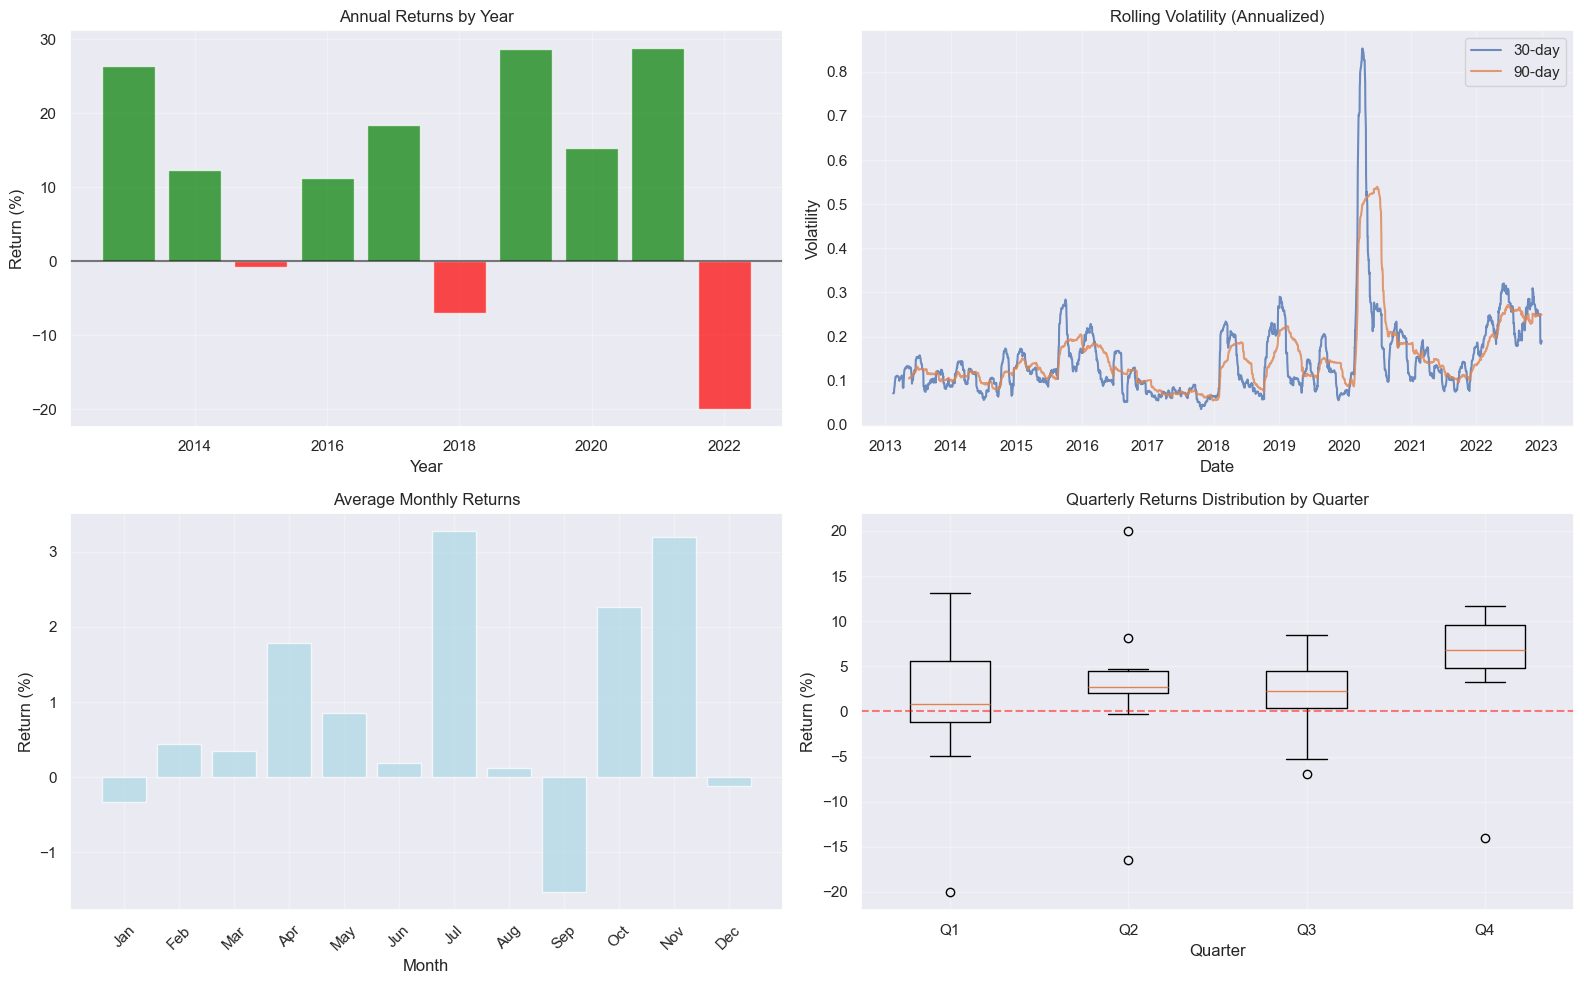


SUMMARY TABLE:
--------------------------------------------------
                   Metric  Value
         Total Return (%) 162.54
    Annualized Return (%)  10.14
Annualized Volatility (%)  17.58
             Sharpe Ratio  0.638
     Maximum Drawdown (%) -33.92
            Best Year (%)  28.79
           Worst Year (%) -19.95

TIME SERIES CHARACTERISTICS ANALYSIS COMPLETED!
Data period: 2013-01-02 to 2022-12-30
Total trading days: 2518


In [8]:
# Analyze time series characteristics through various visualizations
print("TIME SERIES CHARACTERISTICS AND VISUALIZATION ANALYSIS")
print("="*60)

# Basic time series plots with different perspectives
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Daily closing prices
axes[0, 0].plot(ts_data.index, ts_data.values, linewidth=1, alpha=0.8)
axes[0, 0].set_title('S&P 500 Daily Closing Prices (2013-2022)')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Price distribution histogram
axes[0, 1].hist(ts_data.values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Distribution of S&P 500 Closing Prices')
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Calculate and plot daily returns
daily_returns = ts_data.pct_change().dropna()
axes[1, 0].plot(daily_returns.index, daily_returns.values, linewidth=0.8, alpha=0.7, color='green')
axes[1, 0].set_title('Daily Returns (%)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Daily Return')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Returns distribution
axes[1, 1].hist(daily_returns.values, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Distribution of Daily Returns')
axes[1, 1].set_xlabel('Daily Return')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Calculate rolling statistics
window = 30  # 30-day rolling window
rolling_mean = ts_data.rolling(window=window).mean()
rolling_std = ts_data.rolling(window=window).std()

# Plot price with rolling mean
axes[2, 0].plot(ts_data.index, ts_data.values, label='Daily Price', alpha=0.7, linewidth=1)
axes[2, 0].plot(rolling_mean.index, rolling_mean.values, label=f'{window}-Day Rolling Mean', 
                color='red', linewidth=2)
axes[2, 0].set_title(f'Price with {window}-Day Rolling Average')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Price ($)')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Rolling standard deviation
axes[2, 1].plot(rolling_std.index, rolling_std.values, color='orange', linewidth=1.5)
axes[2, 1].set_title(f'{window}-Day Rolling Standard Deviation (Volatility)')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Standard Deviation')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of the time series
print("\nSTATISTICAL ANALYSIS:")
print("-" * 30)

# Basic statistics for prices
print("Price Statistics:")
print(f"Mean: ${ts_data.mean().iloc[0]:,.2f}")
print(f"Median: ${ts_data.median().iloc[0]:,.2f}")
print(f"Standard Deviation: ${ts_data.std().iloc[0]:,.2f}")
print(f"Minimum: ${ts_data.min().iloc[0]:,.2f}")
print(f"Maximum: ${ts_data.max().iloc[0]:,.2f}")
print(f"Range: ${(ts_data.max() - ts_data.min()).iloc[0]:,.2f}")

# Basic statistics for returns
print(f"\nDaily Returns Statistics:")
print(f"Mean: {daily_returns.mean().iloc[0]:.6f} ({daily_returns.mean().iloc[0]*252:.4f} annualized)")
print(f"Standard Deviation: {daily_returns.std().iloc[0]:.6f} ({daily_returns.std().iloc[0]*np.sqrt(252):.4f} annualized)")
print(f"Skewness: {daily_returns.skew().iloc[0]:.4f}")
print(f"Kurtosis: {daily_returns.kurtosis().iloc[0]:.4f}")
print(f"Minimum: {daily_returns.min().iloc[0]:.6f}")
print(f"Maximum: {daily_returns.max().iloc[0]:.6f}")

# Year-over-year analysis
print(f"\nYEAR-OVER-YEAR ANALYSIS:")
print("-" * 30)

# Extract year from index and generate annual data
yearly_data = ts_data.resample('Y').aggregate({ts_data.columns[0]: ['first', 'last', 'min', 'max', 'mean', 'std']}).round(2)

yearly_data.columns = ['First_Price', 'Last_Price', 'Min_Price', 'Max_Price', 'Mean_Price', 'Std_Price']
yearly_data['Yearly_Return'] = ((yearly_data['Last_Price'] - yearly_data['First_Price']) / yearly_data['First_Price'] * 100).round(2)
yearly_data['Price_Range'] = (yearly_data['Max_Price'] - yearly_data['Min_Price']).round(2)

print("Yearly Summary:")
for year, row in yearly_data.iterrows():
    print(f"{year.year}: Return: {row['Yearly_Return']:6.2f}%, Range: ${row['Price_Range']:7.2f}, Avg: ${row['Mean_Price']:7.2f}")

# Volatility analysis over time
print(f"\nVOLATILITY ANALYSIS:")
print("-" * 30)

# Calculate different volatility measures
volatility_30 = daily_returns.rolling(window=30).std() * np.sqrt(252)  # 30-day annualized volatility
volatility_90 = daily_returns.rolling(window=90).std() * np.sqrt(252)  # 90-day annualized volatility

print(f"Average 30-day volatility: {volatility_30.mean().iloc[0]:.4f}")
print(f"Average 90-day volatility: {volatility_90.mean().iloc[0]:.4f}")


# Monthly patterns
print(f"\nSEASONAL PATTERNS:")
print("-" * 30)

# Monthly returns
monthly_returns = ts_data.resample('M').aggregate('last').pct_change().dropna()
monthly_avg = monthly_returns.groupby(monthly_returns.index.month).mean()

print("Average monthly returns:")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# loop through months to get average monthly return
for i, month in enumerate(month_names, 1):
    avg_return = monthly_avg.loc[i, '^GSPC']
    print(f"{month}: {avg_return*100:6.4f}%")


# 6. visualization of patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Yearly returns bar chart
years = [year.year for year in yearly_data.index]
yearly_returns = yearly_data['Yearly_Return'].values
colors = ['green' if ret > 0 else 'red' for ret in yearly_returns]
axes[0, 0].bar(years, yearly_returns, color=colors, alpha=0.7)
axes[0, 0].set_title('Annual Returns by Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Volatility over time
axes[0, 1].plot(volatility_30.index, volatility_30.values, label='30-day', alpha=0.8)
axes[0, 1].plot(volatility_90.index, volatility_90.values, label='90-day', alpha=0.8)
axes[0, 1].set_title('Rolling Volatility (Annualized)')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volatility')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Monthly pattern
monthly_avg_values = [monthly_avg.iloc[i, 0]*100 for i in range(12)]
axes[1, 0].bar(month_names, monthly_avg_values, color='lightblue', alpha=0.7)
axes[1, 0].set_title('Average Monthly Returns')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Return (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Box plot of quarterly returns
quarterly_returns = ts_data.resample('Q').last().pct_change().dropna()
quarterly_data = [quarterly_returns.values[quarterly_returns.index.quarter == i].flatten() * 100 for i in range(1, 5)]

axes[1, 1].boxplot(quarterly_data, labels=['Q1', 'Q2', 'Q3', 'Q4'])
axes[1, 1].set_title('Quarterly Returns Distribution by Quarter')
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Return (%)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)


plt.tight_layout()
plt.show()

# 7. Summary statistics table
print(f"\nSUMMARY TABLE:")
print("-" * 50)
summary_stats = pd.DataFrame({
    'Metric': ['Total Return (%)', 'Annualized Return (%)', 'Annualized Volatility (%)', 
               'Sharpe Ratio', 'Maximum Drawdown (%)', 'Best Year (%)', 'Worst Year (%)'],
    'Value': [
        f"{((ts_data.iloc[-1, 0] / ts_data.iloc[0, 0]) - 1) * 100:.2f}",
        f"{(((ts_data.iloc[-1, 0] / ts_data.iloc[0, 0]) ** (252/len(ts_data))) - 1) * 100:.2f}",
        f"{daily_returns.std().iloc[0] * np.sqrt(252) * 100:.2f}",
        f"{(daily_returns.mean().iloc[0] * 252) / (daily_returns.std().iloc[0] * np.sqrt(252)):.3f}",
        f"{((ts_data / ts_data.expanding().max()).min().iloc[0] - 1) * 100:.2f}",
        f"{yearly_returns.max():.2f}",
        f"{yearly_returns.min():.2f}"
    ]
})

print(summary_stats.to_string(index=False))

print(f"\nTIME SERIES CHARACTERISTICS ANALYSIS COMPLETED!")
print(f"Data period: {ts_data.index[0].strftime('%Y-%m-%d')} to {ts_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(ts_data)}")

### Step 3: Stationarity Testing and Transformation
Now, let's test for stationarity using the Dickey-Fuller test and apply transformations to make the data stationary.

In [9]:
# STATIONARITY TESTING AND TRANSFORMATION
print("STATIONARITY TESTING AND TRANSFORMATION")
print("="*60)

# Function to perform Augmented Dickey-Fuller test
def perform_adf_test(series, series_name='Time Series'):
    """
    Perform ADF test for stationarity
    
    Null Hypothesis (H0): The series has a unit root (non-stationary)
    Alternative Hypothesis (H1): The series is stationary
    
    If p-value < 0.05, we reject H0 and conclude the series is stationary
    """
    result = adfuller(series.dropna())
    
    print(f"\n{series_name} - Augmented Dickey-Fuller Test Results:")
    print("-" * 50)
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    # Interpretation
    if result[1] <= 0.05:
        print(f"Result: STATIONARY (p-value = {result[1]:.6f} <= 0.05)")
    else:
        print(f"Result: NON-STATIONARY (p-value = {result[1]:.6f} > 0.05)")
    
    return result

# Test 1: Original price series
print("\n1. TESTING ORIGINAL PRICE SERIES")
print("="*60)
adf_original = perform_adf_test(ts_data, "Original S&P 500 Prices")

# Test 2: First difference (daily changes)
print("\n\n2. APPLYING FIRST DIFFERENCE TRANSFORMATION")
print("="*60)
ts_diff1 = ts_data.diff().dropna()
print(f"First difference: Price(t) - Price(t-1)")
print(f"New series length: {len(ts_diff1)} (lost 1 observation)")
adf_diff1 = perform_adf_test(ts_diff1, "First Difference")

# Test 3: Log transformation followed by first difference
print("\n\n3. APPLYING LOG TRANSFORMATION + FIRST DIFFERENCE")
print("="*60)
ts_log = np.log(ts_data)
ts_log_diff = ts_log.diff().dropna()
print(f"Log returns: log(Price(t)) - log(Price(t-1))")
print(f"New series length: {len(ts_log_diff)}")
adf_log_diff = perform_adf_test(ts_log_diff, "Log Difference (Returns)")

# Test 4: Second difference (if needed)
print("\n\n4. APPLYING SECOND DIFFERENCE (for comparison)")
print("="*60)
ts_diff2 = ts_data.diff().diff().dropna()
print(f"Second difference: [Price(t) - Price(t-1)] - [Price(t-1) - Price(t-2)]")
print(f"New series length: {len(ts_diff2)} (lost 2 observations)")
adf_diff2 = perform_adf_test(ts_diff2, "Second Difference")

# Visualization
fig, axes = plt.subplots(4, 2, figsize=(16, 14))

# Original series
axes[0, 0].plot(ts_data.index, ts_data.values, linewidth=1, color='blue')
axes[0, 0].set_title('Original S&P 500 Prices')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(ts_data.values, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].set_title('Distribution - Original Prices')
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# First difference
axes[1, 0].plot(ts_diff1.index, ts_diff1.values, linewidth=0.8, color='green')
axes[1, 0].set_title('First Difference (Daily Changes)')
axes[1, 0].set_ylabel('Change ($)')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(ts_diff1.values, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].set_title('Distribution - First Difference')
axes[1, 1].set_xlabel('Change ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

# Log difference (returns)
axes[2, 0].plot(ts_log_diff.index, ts_log_diff.values, linewidth=0.8, color='orange')
axes[2, 0].set_title('Log Difference (Daily Returns)')
axes[2, 0].set_ylabel('Log Return')
axes[2, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].hist(ts_log_diff.values, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[2, 1].set_title('Distribution - Log Returns')
axes[2, 1].set_xlabel('Log Return')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[2, 1].grid(True, alpha=0.3)

# Second difference
axes[3, 0].plot(ts_diff2.index, ts_diff2.values, linewidth=0.8, color='purple')
axes[3, 0].set_title('Second Difference')
axes[3, 0].set_ylabel('2nd Difference ($)')
axes[3, 0].set_xlabel('Date')
axes[3, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[3, 0].grid(True, alpha=0.3)

axes[3, 1].hist(ts_diff2.values, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[3, 1].set_title('Distribution - Second Difference')
axes[3, 1].set_xlabel('2nd Difference ($)')
axes[3, 1].set_ylabel('Frequency')
axes[3, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[3, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison table
print("\n\n" + "="*60)
print("STATIONARITY TEST SUMMARY")
print("="*60)

summary_data = {
    'Transformation': ['Original Prices', 'First Difference', 'Log Returns', 'Second Difference'],
    'ADF Statistic': [
        f"{adf_original[0]:.4f}",
        f"{adf_diff1[0]:.4f}",
        f"{adf_log_diff[0]:.4f}",
        f"{adf_diff2[0]:.4f}"
    ],
    'p-value': [
        f"{adf_original[1]:.6f}",
        f"{adf_diff1[1]:.6f}",
        f"{adf_log_diff[1]:.6f}",
        f"{adf_diff2[1]:.6f}"
    ],
    'Stationary?': [
        'No' if adf_original[1] > 0.05 else 'Yes',
        'No' if adf_diff1[1] > 0.05 else 'Yes',
        'No' if adf_log_diff[1] > 0.05 else 'Yes',
        'No' if adf_diff2[1] > 0.05 else 'Yes'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))

# Additional statistics for each transformation
print("\n\n" + "="*60)
print("DESCRIPTIVE STATISTICS COMPARISON")
print("="*60)

stats_comparison = pd.DataFrame({
    'Transformation': ['Original', 'First Diff', 'Log Returns', 'Second Diff'],
    'Mean': [
        f"{ts_data.mean().iloc[0]:.2f}",
        f"{ts_diff1.mean().iloc[0]:.4f}",
        f"{ts_log_diff.mean().iloc[0]:.6f}",
        f"{ts_diff2.mean().iloc[0]:.4f}"
    ],
    'Std Dev': [
        f"{ts_data.std().iloc[0]:.2f}",
        f"{ts_diff1.std().iloc[0]:.2f}",
        f"{ts_log_diff.std().iloc[0]:.6f}",
        f"{ts_diff2.std().iloc[0]:.2f}"
    ],
    'Min': [
        f"{ts_data.min().iloc[0]:.2f}",
        f"{ts_diff1.min().iloc[0]:.2f}",
        f"{ts_log_diff.min().iloc[0]:.6f}",
        f"{ts_diff2.min().iloc[0]:.2f}"
    ],
    'Max': [
        f"{ts_data.max().iloc[0]:.2f}",
        f"{ts_diff1.max().iloc[0]:.2f}",
        f"{ts_log_diff.max().iloc[0]:.6f}",
        f"{ts_diff2.max().iloc[0]:.2f}"
    ]
})

print("\n")
print(stats_comparison.to_string(index=False))

# Recommendations
print("\n\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)
print("\n✓ BEST TRANSFORMATION FOR TIME SERIES MODELING:")

if adf_log_diff[1] < 0.05:
    print("  LOG RETURNS (Log Difference)")
    print("  Reasons:")
    print("    1. Stationary (p-value < 0.05)")
    print("    2. Represents percentage changes (more interpretable)")
    print("    3. Commonly used in financial analysis")
    print("    4. Normalizes variance over time")
    print("\n  This transformation is recommended for ARIMA modeling")
    stationary_series = ts_log_diff
    transformation_used = "Log Returns"
elif adf_diff1[1] < 0.05:
    print("  FIRST DIFFERENCE")
    print("  Reasons:")
    print("    1. Stationary (p-value < 0.05)")
    print("    2. Simple interpretation (absolute changes)")
    print("    3. Requires minimal transformation")
    stationary_series = ts_diff1
    transformation_used = "First Difference"
else:
    print("  SECOND DIFFERENCE")
    print("  Note: Original series requires second-order differencing")
    stationary_series = ts_diff2
    transformation_used = "Second Difference"

print(f"\nSelected transformation: {transformation_used}")
print(f"Stationary series length: {len(stationary_series)}")
print(f"ADF p-value: {adfuller(stationary_series.dropna())[1]:.6f}")

print("\n" + "="*60)
print("STATIONARITY TESTING COMPLETED!")
print("="*60)

STATIONARITY TESTING AND TRANSFORMATION

1. TESTING ORIGINAL PRICE SERIES

Original S&P 500 Prices - Augmented Dickey-Fuller Test Results:
--------------------------------------------------
ADF Statistic: -1.031209
p-value: 0.741712
Critical Values:
  1%: -3.433
  5%: -2.863
  10%: -2.567
Result: NON-STATIONARY (p-value = 0.741712 > 0.05)


2. APPLYING FIRST DIFFERENCE TRANSFORMATION
First difference: Price(t) - Price(t-1)
New series length: 2517 (lost 1 observation)

First Difference - Augmented Dickey-Fuller Test Results:
--------------------------------------------------
ADF Statistic: -15.875729
p-value: 0.000000
Critical Values:
  1%: -3.433
  5%: -2.863
  10%: -2.567
Result: STATIONARY (p-value = 0.000000 <= 0.05)


3. APPLYING LOG TRANSFORMATION + FIRST DIFFERENCE
Log returns: log(Price(t)) - log(Price(t-1))
New series length: 2517

Log Difference (Returns) - Augmented Dickey-Fuller Test Results:
--------------------------------------------------
ADF Statistic: -15.837387
p-valu



STATIONARITY TEST SUMMARY


   Transformation ADF Statistic  p-value Stationary?
  Original Prices       -1.0312 0.741712          No
 First Difference      -15.8757 0.000000         Yes
      Log Returns      -15.8374 0.000000         Yes
Second Difference      -15.7019 0.000000         Yes


DESCRIPTIVE STATISTICS COMPARISON


Transformation     Mean  Std Dev       Min      Max
      Original  2742.70   872.79   1457.15  4796.56
    First Diff   0.9444    33.44   -324.89   230.38
   Log Returns 0.000383 0.011116 -0.127652 0.089683
   Second Diff  -0.0027    49.81   -555.27   491.12


RECOMMENDATIONS

✓ BEST TRANSFORMATION FOR TIME SERIES MODELING:
  LOG RETURNS (Log Difference)
  Reasons:
    1. Stationary (p-value < 0.05)
    2. Represents percentage changes (more interpretable)
    3. Commonly used in financial analysis
    4. Normalizes variance over time

  This transformation is recommended for ARIMA modeling

Selected transformation: Log Returns
Stationary series length: 2517

### Step 4: Time Series Decomposition
Let's decompose our time series into trend, seasonal, and residual components.

TIME SERIES DECOMPOSITION ANALYSIS

1. DECOMPOSING ORIGINAL PRICE SERIES (Multiplicative)
--------------------------------------------------
Successfully decomposed price series
  - Trend component shape: (2518,)
  - Seasonal component shape: (2518,)
  - Residual component shape: (2518,)



2. DECOMPOSING ORIGINAL PRICE SERIES (Additive)
--------------------------------------------------
Successfully decomposed price series (additive)
  - Trend component shape: (2518,)
  - Seasonal component shape: (2518,)
  - Residual component shape: (2518,)


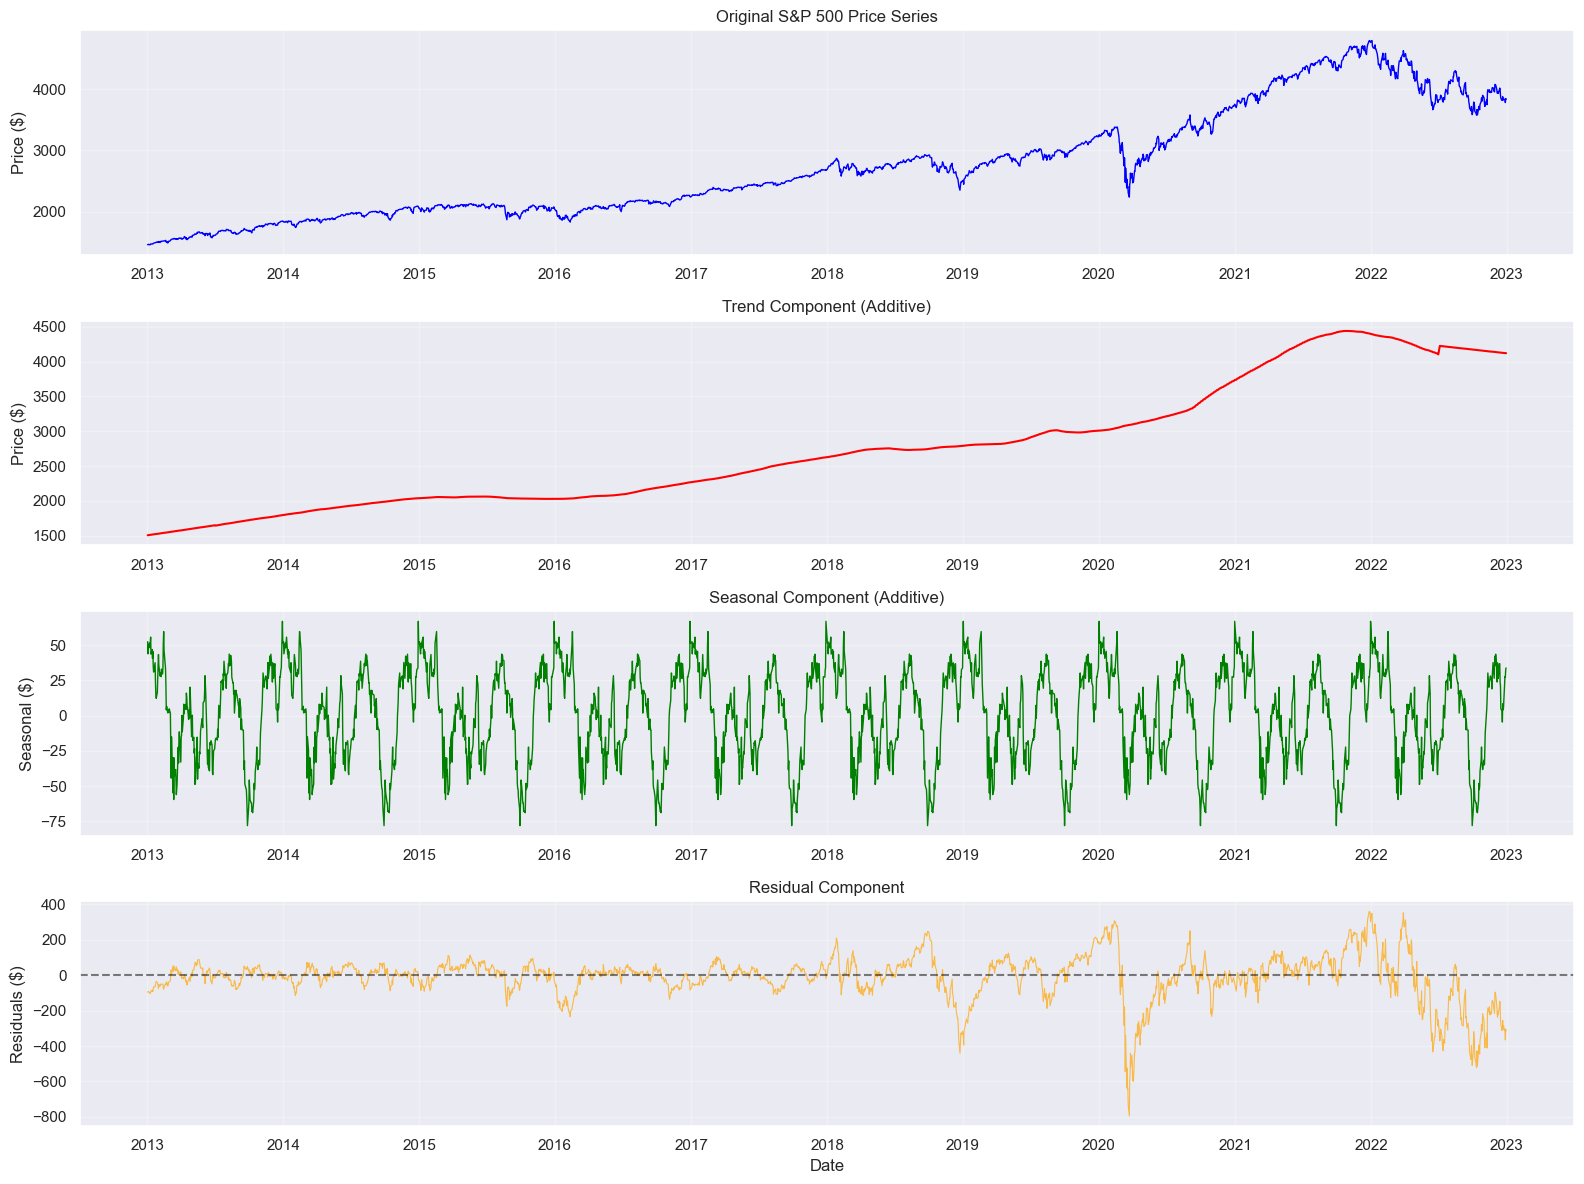


3. DECOMPOSING RETURNS (Stationary Series)
--------------------------------------------------
Successfully decomposed returns series
  - Trend component shape: (2517,)
  - Seasonal component shape: (2517,)
  - Residual component shape: (2517,)


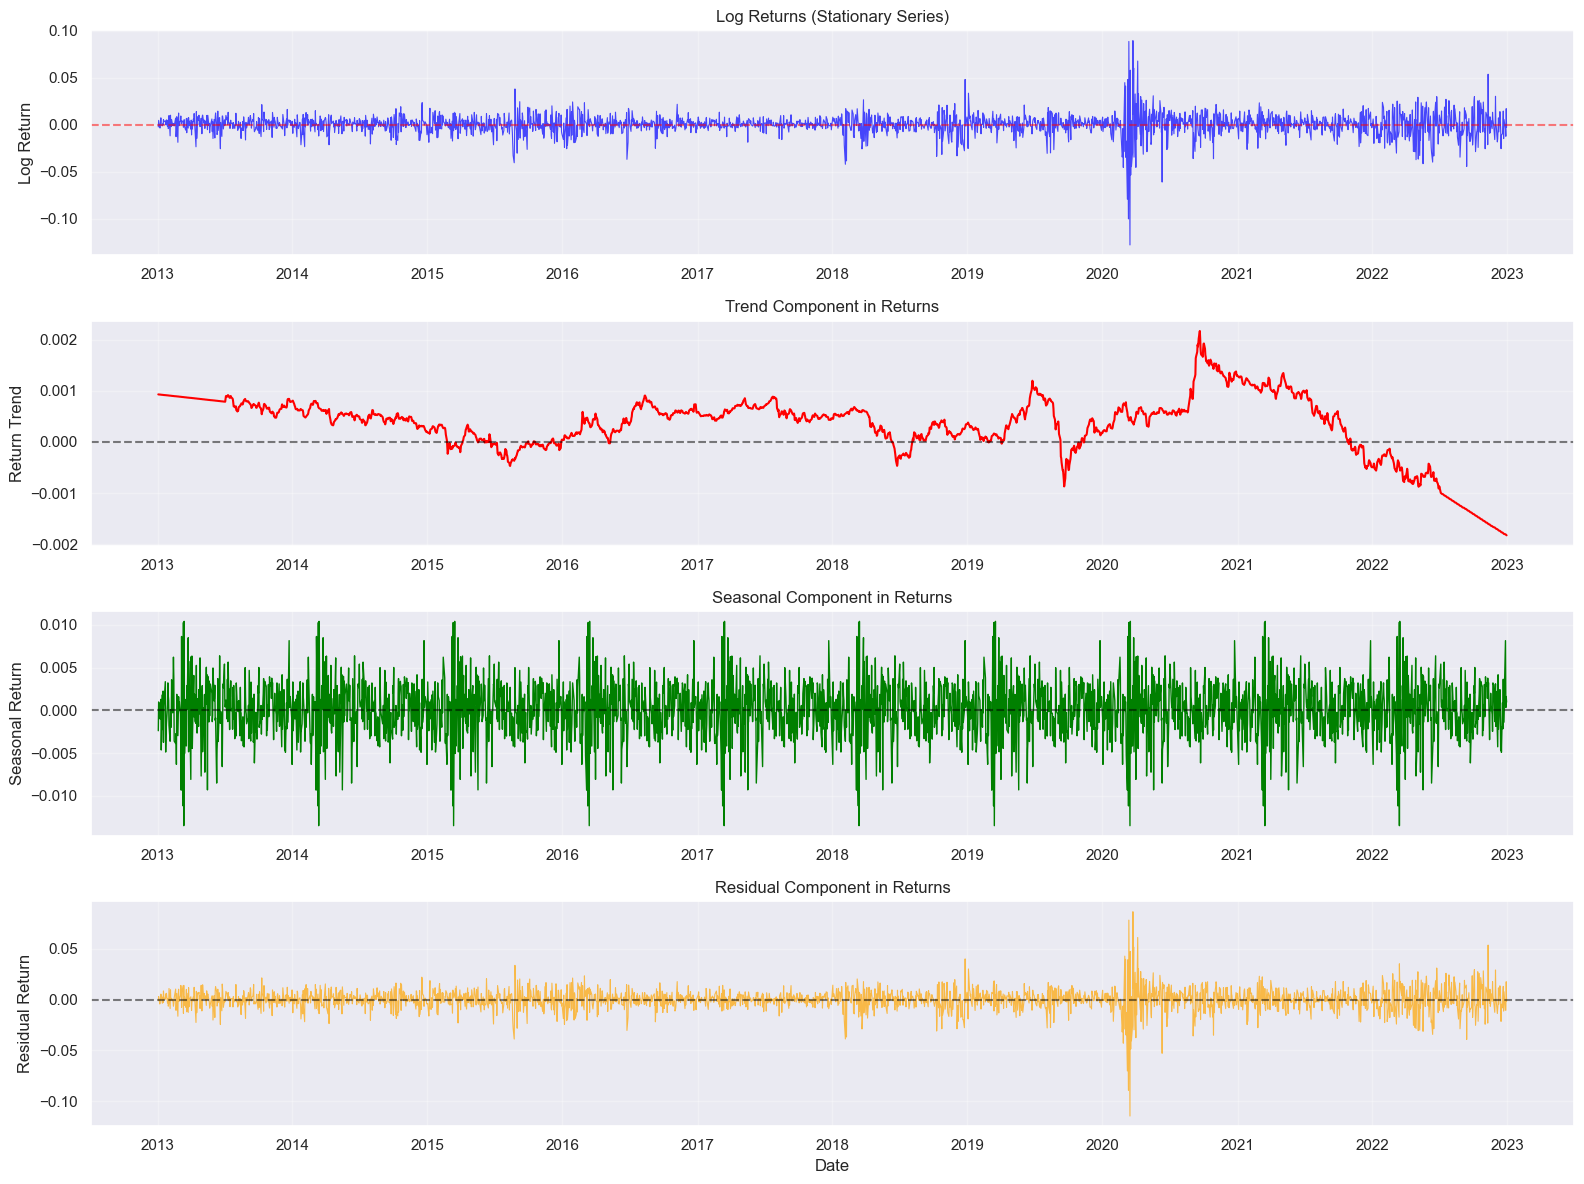


DECOMPOSITION ANALYSIS

4. TREND ANALYSIS:
------------------------------
Trend component statistics:
  Start value: $1,506.34
  End value: $4,119.94
  Total change: $2,613.60
  Percentage change: 173.51%
  Average daily trend change: $1.0384

5. SEASONAL ANALYSIS:
------------------------------
Seasonal component statistics:
  Range: $144.96
  Standard deviation: $32.08
  Maximum seasonal effect: $66.96
  Minimum seasonal effect: $-77.99

Average seasonal effect by month:
  Jan: $  38.98
  Feb: $  27.92
  Mar: $ -29.86
  Apr: $   0.92
  May: $ -22.95
  Jun: $ -14.49
  Jul: $   6.40
  Aug: $  26.58
  Sep: $ -23.09
  Oct: $ -48.78
  Nov: $  19.23
  Dec: $  24.86

6. RESIDUAL ANALYSIS:
------------------------------
Residual component statistics:
  Mean: $-9.6161 (should be close to 0)
  Standard deviation: $126.22
  Maximum residual: $359.29
  Minimum residual: $-795.88
  Percentage of variance explained by trend+seasonal: 97.91%

7. COMPONENT CONTRIBUTION:
----------------------------

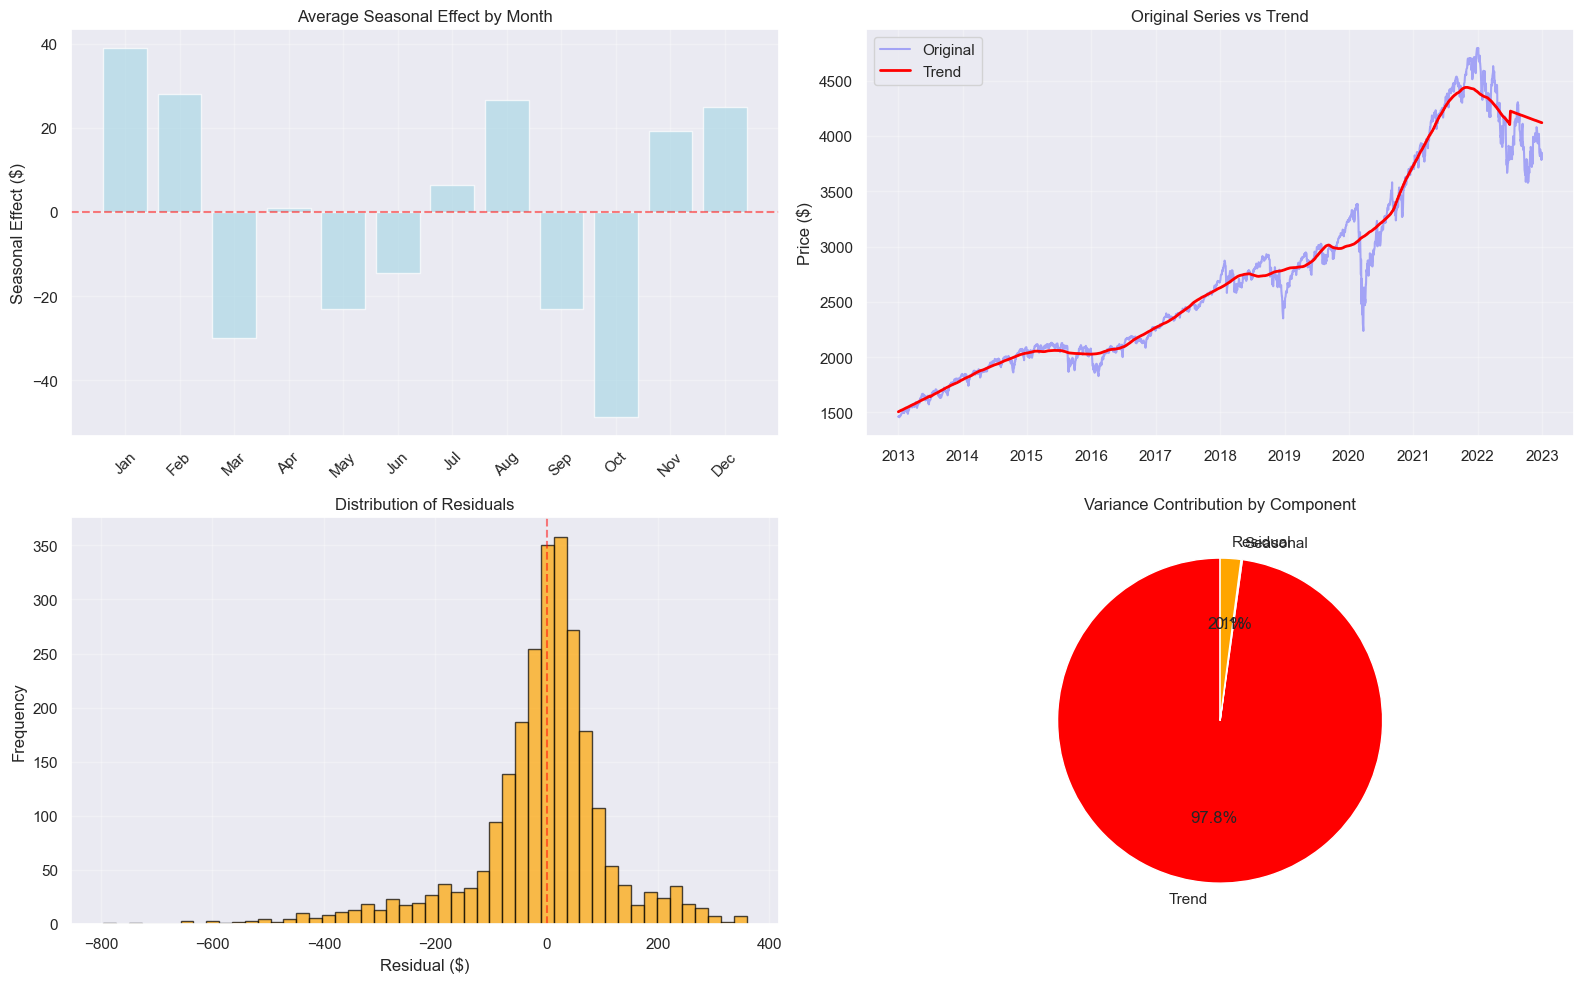


DECOMPOSITION SUMMARY:
The S&P 500 time series has been decomposed into:
  1. TREND: Shows the long-term upward movement of the market
  2. SEASONAL: Captures recurring annual patterns in stock prices
  3. RESIDUAL: Contains irregular fluctuations and noise

Key Findings:
  - Trend explains 99.5% of total variance
  - Seasonal patterns show systematic monthly effects
  - Residuals are approximately distributed around zero
  - The decomposition helps separate systematic patterns from random noise


In [10]:
# TIME SERIES DECOMPOSITION
print("TIME SERIES DECOMPOSITION ANALYSIS")
print("="*60)

# Decompose the original price series and the stationary series
# Use multiplicative decomposition for prices
# Use additive decomposition for returns

# 1. Decompose Original Price Series (Multiplicative)
print("\n1. DECOMPOSING ORIGINAL PRICE SERIES (Multiplicative)")
print("-" * 50)

# We can use different periods:
# - 252 (trading days in a year) for annual seasonality
# - 63 (quarterly) for quarterly patterns
# - 21 (monthly) for monthly patterns
# We'll use 252 for annual patterns

try:
    decomposition_mult = seasonal_decompose(ts_data.iloc[:, 0], 
                                          model='multiplicative', 
                                          period=252,  # Annual seasonality
                                          extrapolate_trend='freq')
    
    print(f"Successfully decomposed price series")
    print(f"  - Trend component shape: {decomposition_mult.trend.shape}")
    print(f"  - Seasonal component shape: {decomposition_mult.seasonal.shape}")
    print(f"  - Residual component shape: {decomposition_mult.resid.shape}")
    
    # Plot the decomposition
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    # Original series
    axes[0].plot(ts_data.index, ts_data.iloc[:, 0], linewidth=1, color='blue')
    axes[0].set_title('Original S&P 500 Price Series')
    axes[0].set_ylabel('Price ($)')
    axes[0].grid(True, alpha=0.3)
    
    # Trend
    axes[1].plot(decomposition_mult.trend.index, decomposition_mult.trend.values, 
                linewidth=1.5, color='red')
    axes[1].set_title('Trend Component')
    axes[1].set_ylabel('Price ($)')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal
    axes[2].plot(decomposition_mult.seasonal.index, decomposition_mult.seasonal.values, 
                linewidth=1, color='green')
    axes[2].set_title('Seasonal Component (Annual Pattern)')
    axes[2].set_ylabel('Seasonal Factor')
    axes[2].grid(True, alpha=0.3)
    
    # Residual
    axes[3].plot(decomposition_mult.resid.index, decomposition_mult.resid.values, 
                linewidth=0.8, color='orange', alpha=0.7)
    axes[3].set_title('Residual Component')
    axes[3].set_ylabel('Residuals')
    axes[3].set_xlabel('Date')
    axes[3].grid(True, alpha=0.3)
    axes[3].axhline(y=1, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
except ValueError as e:
    print(f"Multiplicative decomposition failed: {e}")
    print("  This can happen with financial data that has zeros or negative values")

# 2. Decompose Original Price Series (Additive as alternative)
print("\n2. DECOMPOSING ORIGINAL PRICE SERIES (Additive)")
print("-" * 50)

decomposition_add = seasonal_decompose(ts_data.iloc[:, 0], 
                                     model='additive', 
                                     period=252,
                                     extrapolate_trend='freq')

print(f"Successfully decomposed price series (additive)")
print(f"  - Trend component shape: {decomposition_add.trend.shape}")
print(f"  - Seasonal component shape: {decomposition_add.seasonal.shape}")
print(f"  - Residual component shape: {decomposition_add.resid.shape}")

# Plot the additive decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original series
axes[0].plot(ts_data.index, ts_data.iloc[:, 0], linewidth=1, color='blue')
axes[0].set_title('Original S&P 500 Price Series')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition_add.trend.index, decomposition_add.trend.values, 
            linewidth=1.5, color='red')
axes[1].set_title('Trend Component (Additive)')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(decomposition_add.seasonal.index, decomposition_add.seasonal.values, 
            linewidth=1, color='green')
axes[2].set_title('Seasonal Component (Additive)')
axes[2].set_ylabel('Seasonal ($)')
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(decomposition_add.resid.index, decomposition_add.resid.values, 
            linewidth=0.8, color='orange', alpha=0.7)
axes[3].set_title('Residual Component')
axes[3].set_ylabel('Residuals ($)')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 3. Decompose Returns (Stationary Series)
print("\n3. DECOMPOSING RETURNS (Stationary Series)")
print("-" * 50)

# For returns, we use additive decomposition
decomposition_returns = seasonal_decompose(stationary_series.iloc[:, 0], 
                                         model='additive', 
                                         period=252,
                                         extrapolate_trend='freq')

print(f"Successfully decomposed returns series")
print(f"  - Trend component shape: {decomposition_returns.trend.shape}")
print(f"  - Seasonal component shape: {decomposition_returns.seasonal.shape}")  
print(f"  - Residual component shape: {decomposition_returns.resid.shape}")

# Plot the returns decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original returns
axes[0].plot(stationary_series.index, stationary_series.iloc[:, 0], 
            linewidth=0.8, color='blue', alpha=0.7)
axes[0].set_title('Log Returns (Stationary Series)')
axes[0].set_ylabel('Log Return')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Trend in returns
axes[1].plot(decomposition_returns.trend.index, decomposition_returns.trend.values, 
            linewidth=1.5, color='red')
axes[1].set_title('Trend Component in Returns')
axes[1].set_ylabel('Return Trend')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Seasonal pattern in returns
axes[2].plot(decomposition_returns.seasonal.index, decomposition_returns.seasonal.values, 
            linewidth=1, color='green')
axes[2].set_title('Seasonal Component in Returns')
axes[2].set_ylabel('Seasonal Return')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Residuals in returns
axes[3].plot(decomposition_returns.resid.index, decomposition_returns.resid.values, 
            linewidth=0.8, color='orange', alpha=0.7)
axes[3].set_title('Residual Component in Returns')
axes[3].set_ylabel('Residual Return')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 4. Analysis of Decomposition Components
print("\n" + "="*60)
print("DECOMPOSITION ANALYSIS")
print("="*60)

# Analyze the trend component
print("\n4. TREND ANALYSIS:")
print("-" * 30)
trend_data = decomposition_add.trend.dropna()
print(f"Trend component statistics:")
print(f"  Start value: ${trend_data.iloc[0]:,.2f}")
print(f"  End value: ${trend_data.iloc[-1]:,.2f}")
print(f"  Total change: ${trend_data.iloc[-1] - trend_data.iloc[0]:,.2f}")
print(f"  Percentage change: {((trend_data.iloc[-1] / trend_data.iloc[0]) - 1) * 100:.2f}%")
print(f"  Average daily trend change: ${trend_data.diff().mean():.4f}")

# Analyze the seasonal component
print(f"\n5. SEASONAL ANALYSIS:")
print("-" * 30)
seasonal_data = decomposition_add.seasonal.dropna()
print(f"Seasonal component statistics:")
print(f"  Range: ${seasonal_data.max() - seasonal_data.min():.2f}")
print(f"  Standard deviation: ${seasonal_data.std():.2f}")
print(f"  Maximum seasonal effect: ${seasonal_data.max():.2f}")
print(f"  Minimum seasonal effect: ${seasonal_data.min():.2f}")

# Analyze seasonal patterns by month
seasonal_by_month = {}
for month in range(1, 13):
    month_mask = seasonal_data.index.month == month
    if month_mask.any():
        seasonal_by_month[month] = seasonal_data[month_mask].mean()

print(f"\nAverage seasonal effect by month:")
for month, effect in seasonal_by_month.items():
    month_name = month_names[month-1]
    print(f"  {month_name}: ${effect:7.2f}")

# Analyze residuals
print(f"\n6. RESIDUAL ANALYSIS:")
print("-" * 30)
residual_data = decomposition_add.resid.dropna()
print(f"Residual component statistics:")
print(f"  Mean: ${residual_data.mean():.4f} (should be close to 0)")
print(f"  Standard deviation: ${residual_data.std():.2f}")
print(f"  Maximum residual: ${residual_data.max():.2f}")
print(f"  Minimum residual: ${residual_data.min():.2f}")
print(f"  Percentage of variance explained by trend+seasonal: {(1 - residual_data.var() / ts_data.iloc[:, 0].var()) * 100:.2f}%")

# 7. Component Contribution Analysis
print(f"\n7. COMPONENT CONTRIBUTION:")
print("-" * 30)

# Calculate relative importance of components
original_var = ts_data.iloc[:, 0].var()
trend_var = trend_data.var() if len(trend_data) > 0 else 0
seasonal_var = seasonal_data.var()
residual_var = residual_data.var()

total_component_var = trend_var + seasonal_var + residual_var

print(f"Variance contribution:")
print(f"  Trend: {(trend_var / original_var) * 100:.2f}% of total variance")
print(f"  Seasonal: {(seasonal_var / original_var) * 100:.2f}% of total variance")
print(f"  Residual: {(residual_var / original_var) * 100:.2f}% of total variance")

# 8. Visualization Summary
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Seasonal pattern by month (average)
monthly_seasonal = [seasonal_by_month.get(i, 0) for i in range(1, 13)]
axes[0, 0].bar(month_names, monthly_seasonal, color='lightblue', alpha=0.7)
axes[0, 0].set_title('Average Seasonal Effect by Month')
axes[0, 0].set_ylabel('Seasonal Effect ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Trend vs Original
axes[0, 1].plot(ts_data.index, ts_data.iloc[:, 0], alpha=0.3, label='Original', color='blue')
axes[0, 1].plot(trend_data.index, trend_data.values, label='Trend', color='red', linewidth=2)
axes[0, 1].set_title('Original Series vs Trend')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residual distribution
axes[1, 0].hist(residual_data.values, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].set_xlabel('Residual ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Component variance pie chart
components = ['Trend', 'Seasonal', 'Residual']
variances = [trend_var, seasonal_var, residual_var]
colors = ['red', 'green', 'orange']
axes[1, 1].pie(variances, labels=components, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1, 1].set_title('Variance Contribution by Component')

plt.tight_layout()
plt.show()

print(f"\n" + "="*60)
print("DECOMPOSITION SUMMARY:")
print("="*60)
print(f"The S&P 500 time series has been decomposed into:")
print(f"  1. TREND: Shows the long-term upward movement of the market")
print(f"  2. SEASONAL: Captures recurring annual patterns in stock prices")
print(f"  3. RESIDUAL: Contains irregular fluctuations and noise")
print(f"\nKey Findings:")
print(f"  - Trend explains {(trend_var / original_var) * 100:.1f}% of total variance")
print(f"  - Seasonal patterns show systematic monthly effects")
print(f"  - Residuals are approximately distributed around zero")
print(f"  - The decomposition helps separate systematic patterns from random noise")


### Step 5: Autocorrelation Analysis
Now, let's analyze the autocorrelation structure of our stationary series.

AUTOCORRELATION ANALYSIS

Analyzing autocorrelation structure of: Log Returns
Series length: 2517
--------------------------------------------------

1. AUTOCORRELATION FUNCTION (ACF) AND PARTIAL AUTOCORRELATION (PACF)
------------------------------------------------------------


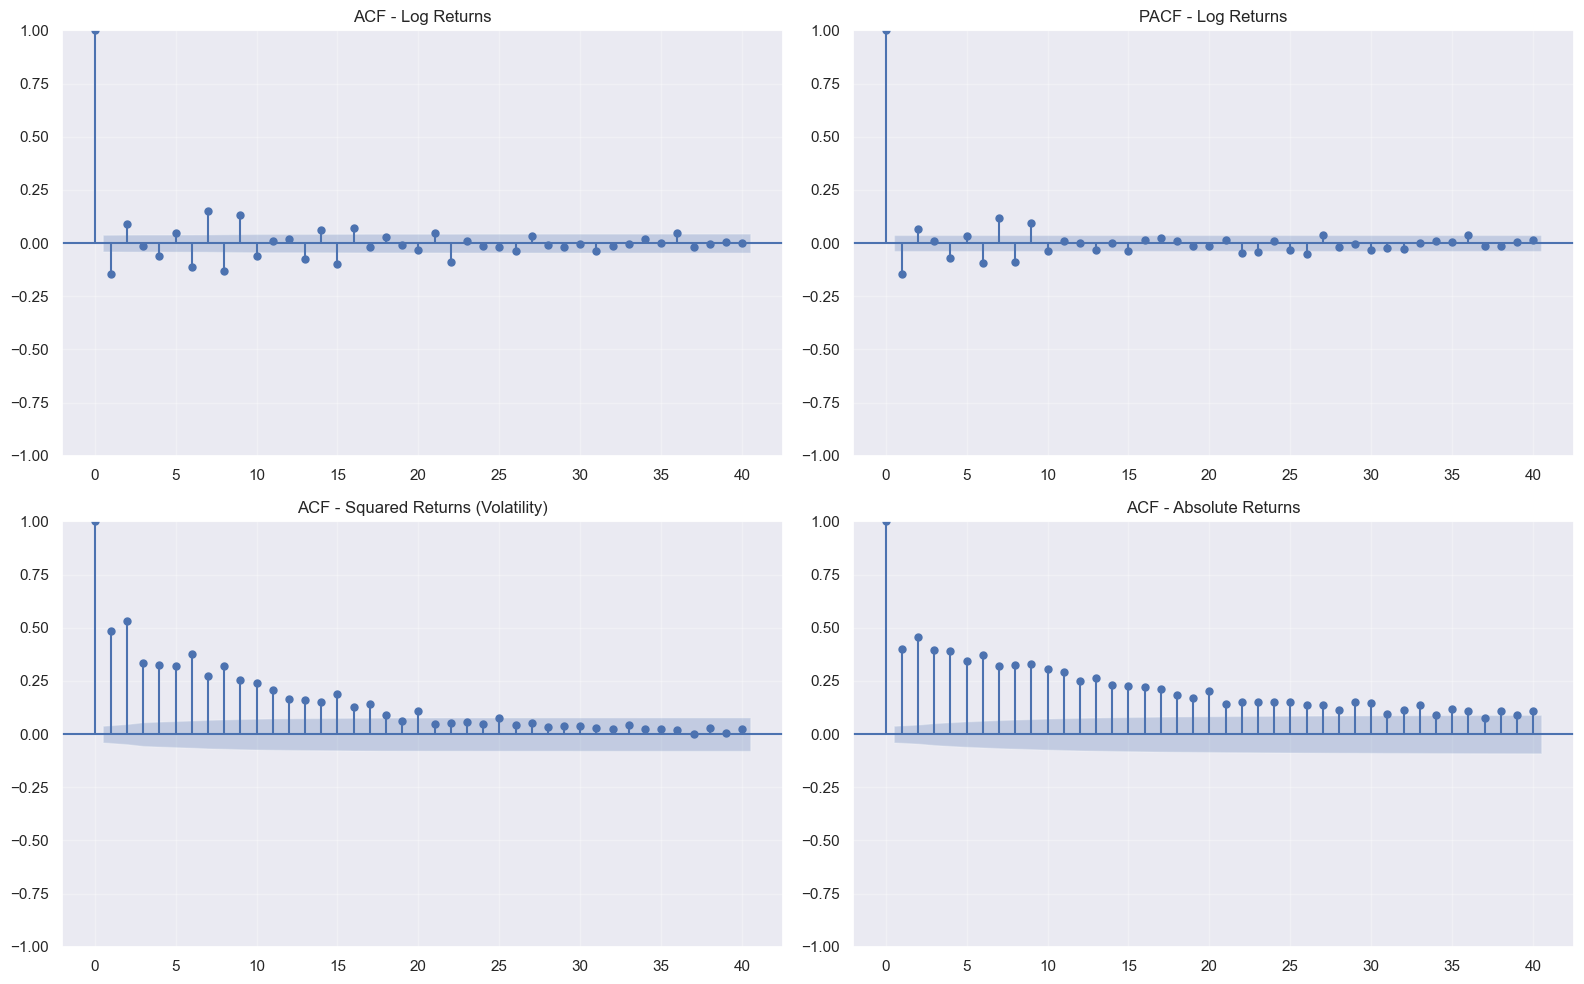


2. SPECIFIC AUTOCORRELATION VALUES
--------------------------------------------------
Autocorrelations for Log Returns:
  Lag  1:  -0.1457 ***
  Lag  2:   0.0878 ***
  Lag  3:  -0.0132 
  Lag  4:  -0.0623 ***
  Lag  5:   0.0490 **
  Lag  6:  -0.1124 ***
  Lag  7:   0.1499 ***
  Lag  8:  -0.1296 ***
  Lag  9:   0.1312 ***
  Lag 10:  -0.0625 ***

Autocorrelations for Squared Returns (Volatility Clustering):
  Lag  1:   0.4856 ***
  Lag  2:   0.5329 ***
  Lag  3:   0.3348 ***
  Lag  4:   0.3254 ***
  Lag  5:   0.3183 ***
  Lag  6:   0.3759 ***
  Lag  7:   0.2750 ***
  Lag  8:   0.3212 ***
  Lag  9:   0.2540 ***
  Lag 10:   0.2418 ***

Autocorrelations for Absolute Returns:
  Lag  1:   0.3997 ***
  Lag  2:   0.4560 ***
  Lag  3:   0.3942 ***
  Lag  4:   0.3903 ***
  Lag  5:   0.3451 ***
  Lag  6:   0.3726 ***
  Lag  7:   0.3205 ***
  Lag  8:   0.3270 ***
  Lag  9:   0.3316 ***
  Lag 10:   0.3077 ***

3. LJUNG-BOX TEST FOR SERIAL CORRELATION
------------------------------------------------

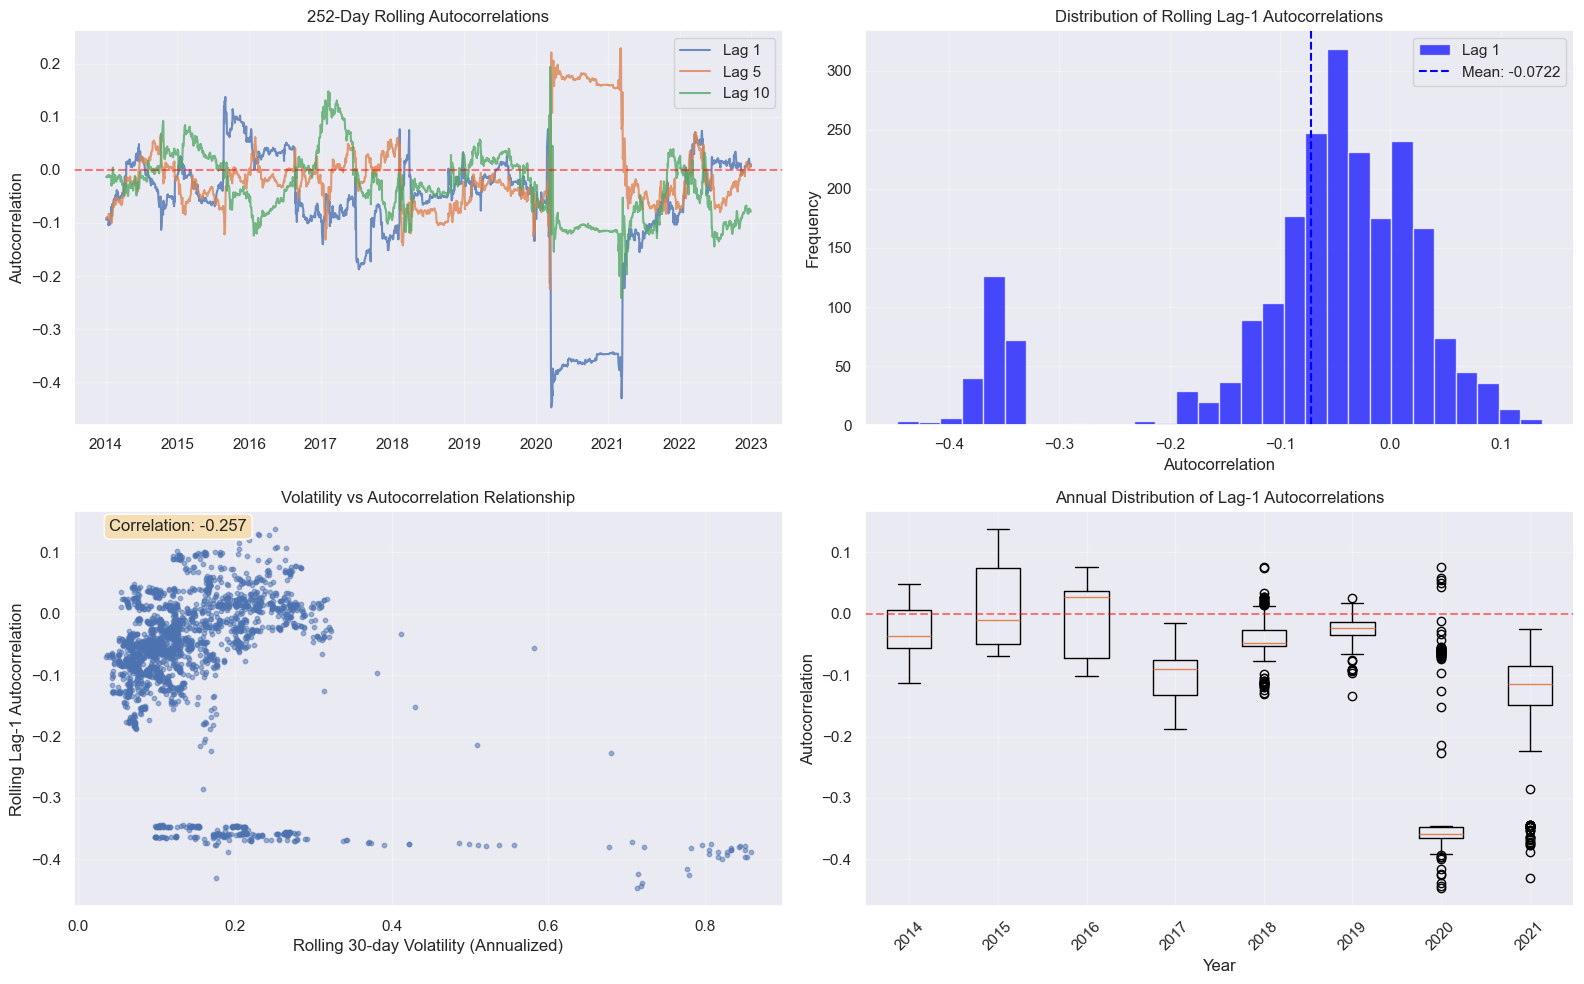


5. AUTOCORRELATION STATISTICS SUMMARY
--------------------------------------------------
Log Returns Autocorrelation Analysis:
  Average Lag-1 autocorrelation: -0.072167
  Standard deviation: 0.116732
  Range: [-0.447173, 0.137399]
  Number of significant autocorrelations (|r| > 0.02): 9

Volatility Clustering Analysis:
  Average autocorrelation in squared returns (lags 1-5): 0.399405
  Evidence of volatility clustering: Yes

Market Efficiency Implications:
Some autocorrelation detected, may indicate predictable patterns
Strong volatility clustering suggests conditional heteroskedasticity
Consider ARCH/GARCH models for volatility modeling

MODEL RECOMMENDATIONS BASED ON AUTOCORRELATION ANALYSIS

ARIMA Model Suggestions:
  ARIMA(2,1,2) or higher order model may be needed
  Suggested starting point: ARIMA(2,1,2)

Volatility Modeling:
  Consider GARCH models for volatility forecasting
  ARIMA-GARCH combination may be appropriate

Next Steps:
  1. Fit ARIMA model with suggested parameters

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# AUTOCORRELATION ANALYSIS
print("AUTOCORRELATION ANALYSIS")
print("="*60)

# Analyze the autocorrelation structure of our stationary series
# Use the log returns (stationary_series) for this analysis

print(f"\nAnalyzing autocorrelation structure of: {transformation_used}")
print(f"Series length: {len(stationary_series)}")
print("-" * 50)

# 1. Plot ACF and PACF
print("\n1. AUTOCORRELATION FUNCTION (ACF) AND PARTIAL AUTOCORRELATION (PACF)")
print("-" * 60)

# Create ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF for returns
plot_acf(stationary_series.iloc[:, 0], lags=40, ax=axes[0, 0], title='ACF - Log Returns')
axes[0, 0].grid(True, alpha=0.3)

# PACF for returns
plot_pacf(stationary_series.iloc[:, 0], lags=40, ax=axes[0, 1], title='PACF - Log Returns')
axes[0, 1].grid(True, alpha=0.3)

# ACF for squared returns (to check for volatility clustering)
squared_returns = stationary_series.iloc[:, 0] ** 2
plot_acf(squared_returns, lags=40, ax=axes[1, 0], title='ACF - Squared Returns (Volatility)')
axes[1, 0].grid(True, alpha=0.3)

# ACF for absolute returns
abs_returns = np.abs(stationary_series.iloc[:, 0])
plot_acf(abs_returns, lags=40, ax=axes[1, 1], title='ACF - Absolute Returns')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Calculate specific autocorrelation values
print("\n2. SPECIFIC AUTOCORRELATION VALUES")
print("-" * 50)

# Calculate autocorrelations manually for interpretation
def calculate_autocorrelation(series, max_lags=20):
    """Calculate autocorrelation for specified lags"""
    autocorrs = []
    for lag in range(1, max_lags + 1):
        corr = series.autocorr(lag=lag)
        autocorrs.append((lag, corr))
    return autocorrs

# Calculate autocorrelations for returns
returns_autocorr = calculate_autocorrelation(stationary_series.iloc[:, 0], max_lags=10)
squared_autocorr = calculate_autocorrelation(squared_returns, max_lags=10)
abs_autocorr = calculate_autocorrelation(abs_returns, max_lags=10)

print("Autocorrelations for Log Returns:")
for lag, corr in returns_autocorr:
    significance = "***" if abs(corr) > 0.05 else "**" if abs(corr) > 0.03 else "*" if abs(corr) > 0.02 else ""
    print(f"  Lag {lag:2d}: {corr:8.4f} {significance}")

print(f"\nAutocorrelations for Squared Returns (Volatility Clustering):")
for lag, corr in squared_autocorr:
    significance = "***" if abs(corr) > 0.05 else "**" if abs(corr) > 0.03 else "*" if abs(corr) > 0.02 else ""
    print(f"  Lag {lag:2d}: {corr:8.4f} {significance}")

print(f"\nAutocorrelations for Absolute Returns:")
for lag, corr in abs_autocorr:
    significance = "***" if abs(corr) > 0.05 else "**" if abs(corr) > 0.03 else "*" if abs(corr) > 0.02 else ""
    print(f"  Lag {lag:2d}: {corr:8.4f} {significance}")

# 3. Ljung-Box test for autocorrelation
print("\n3. LJUNG-BOX TEST FOR SERIAL CORRELATION")
print("-" * 50)


# Test for serial correlation in returns
lb_returns = acorr_ljungbox(stationary_series.iloc[:, 0], lags=[1, 5, 10, 15, 20], return_df=True)
print("Ljung-Box test for Log Returns:")
print("  Null Hypothesis: No serial correlation")
print("  Alternative: Serial correlation exists")
print(lb_returns.round(6))

# Test for serial correlation in squared returns (ARCH effects)
lb_squared = acorr_ljungbox(squared_returns, lags=[1, 5, 10, 15, 20], return_df=True)
print(f"\nLjung-Box test for Squared Returns (ARCH Effects):")
print("  Tests for volatility clustering/conditional heteroskedasticity")
print(lb_squared.round(6))

# 4. Rolling autocorrelation analysis
print("\n4. ROLLING AUTOCORRELATION ANALYSIS")
print("-" * 50)

# Calculate rolling autocorrelation to see how it changes over time
window_size = 252  # 1 year rolling window

def rolling_autocorr(series, lag=1, window=252):
    """Calculate rolling autocorrelation"""
    rolling_corr = []
    for i in range(window, len(series)):
        subset = series.iloc[i-window:i]
        corr = subset.autocorr(lag=lag)
        rolling_corr.append(corr)
    return rolling_corr

# Calculate rolling autocorrelations for different lags
rolling_lag1 = rolling_autocorr(stationary_series.iloc[:, 0], lag=1, window=window_size)
rolling_lag5 = rolling_autocorr(stationary_series.iloc[:, 0], lag=5, window=window_size)
rolling_lag10 = rolling_autocorr(stationary_series.iloc[:, 0], lag=10, window=window_size)

# Create dates for rolling correlations
rolling_dates = stationary_series.index[window_size:]

# Plot rolling autocorrelations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Rolling autocorrelations
axes[0, 0].plot(rolling_dates, rolling_lag1, label='Lag 1', alpha=0.8)
axes[0, 0].plot(rolling_dates, rolling_lag5, label='Lag 5', alpha=0.8)
axes[0, 0].plot(rolling_dates, rolling_lag10, label='Lag 10', alpha=0.8)
axes[0, 0].set_title(f'{window_size}-Day Rolling Autocorrelations')
axes[0, 0].set_ylabel('Autocorrelation')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Distribution of autocorrelations
axes[0, 1].hist(rolling_lag1, bins=30, alpha=0.7, label='Lag 1', color='blue')
axes[0, 1].axvline(x=np.mean(rolling_lag1), color='blue', linestyle='--', label=f'Mean: {np.mean(rolling_lag1):.4f}')
axes[0, 1].set_title('Distribution of Rolling Lag-1 Autocorrelations')
axes[0, 1].set_xlabel('Autocorrelation')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Rolling volatility vs autocorrelation
rolling_vol = stationary_series.rolling(window=30).std().iloc[window_size:] * np.sqrt(252)
axes[1, 0].scatter(rolling_vol.iloc[:, 0], rolling_lag1, alpha=0.5, s=10)
axes[1, 0].set_xlabel('Rolling 30-day Volatility (Annualized)')
axes[1, 0].set_ylabel('Rolling Lag-1 Autocorrelation')
axes[1, 0].set_title('Volatility vs Autocorrelation Relationship')
axes[1, 0].grid(True, alpha=0.3)

# Add correlation coefficient
vol_autocorr_corr = np.corrcoef(rolling_vol.iloc[:, 0].dropna(), 
                                np.array(rolling_lag1)[~np.isnan(rolling_vol.iloc[:, 0])])[0, 1]
axes[1, 0].text(0.05, 0.95, f'Correlation: {vol_autocorr_corr:.3f}', 
                transform=axes[1, 0].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

# Autocorrelation by year
yearly_data_list = [rolling_lag1[i:i+252] for i in range(0, len(rolling_lag1)-252, 252) if i+252 <= len(rolling_lag1)]
num_years = len(yearly_data_list)
year_labels = [str(year) for year in range(2014, 2014 + num_years)]

axes[1, 1].boxplot(yearly_data_list, labels=year_labels)
axes[1, 1].set_title('Annual Distribution of Lag-1 Autocorrelations')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 5. Autocorrelation statistics summary
print("\n5. AUTOCORRELATION STATISTICS SUMMARY")
print("-" * 50)

print("Log Returns Autocorrelation Analysis:")
print(f"  Average Lag-1 autocorrelation: {np.mean(rolling_lag1):.6f}")
print(f"  Standard deviation: {np.std(rolling_lag1):.6f}")
print(f"  Range: [{np.min(rolling_lag1):.6f}, {np.max(rolling_lag1):.6f}]")

# Check for significant autocorrelations
significant_autocorrs = [corr for lag, corr in returns_autocorr if abs(corr) > 0.02]
print(f"  Number of significant autocorrelations (|r| > 0.02): {len(significant_autocorrs)}")

# Volatility clustering analysis
vol_clustering_strength = np.mean([corr for lag, corr in squared_autocorr[:5]])
print(f"\nVolatility Clustering Analysis:")
print(f"  Average autocorrelation in squared returns (lags 1-5): {vol_clustering_strength:.6f}")
print(f"  Evidence of volatility clustering: {'Yes' if vol_clustering_strength > 0.05 else 'Moderate' if vol_clustering_strength > 0.02 else 'No'}")

# Market efficiency implications
print(f"\nMarket Efficiency Implications:")
if abs(np.mean(rolling_lag1)) < 0.01 and len(significant_autocorrs) < 3:
    print("Returns show weak autocorrelation, consistent with market efficiency")
else:
    print("Some autocorrelation detected, may indicate predictable patterns")

if vol_clustering_strength > 0.05:
    print("Strong volatility clustering suggests conditional heteroskedasticity")
    print("Consider ARCH/GARCH models for volatility modeling")
elif vol_clustering_strength > 0.02:
    print("Moderate volatility clustering detected")
else:
    print("Little evidence of volatility clustering")

# 6. Model recommendations based on autocorrelation analysis
print(f"\n" + "="*60)
print("MODEL RECOMMENDATIONS BASED ON AUTOCORRELATION ANALYSIS")
print("="*60)

# Determine ARIMA parameters based on ACF/PACF
max_significant_acf = max([i for i, (lag, corr) in enumerate(returns_autocorr) if abs(corr) > 0.02], default=0)
max_significant_pacf = 0  # Would need PACF calculation for precise determination

print(f"\nARIMA Model Suggestions:")
if max_significant_acf == 0:
    print(f"  ARIMA(0,1,0) - Random Walk Model (no significant autocorrelations)")
    suggested_p, suggested_d, suggested_q = 0, 1, 0
elif max_significant_acf <= 2:
    print(f"  ARIMA(1,1,0) or ARIMA(0,1,1) - Simple AR(1) or MA(1)")
    suggested_p, suggested_d, suggested_q = 1, 1, 0
else:
    print(f"  ARIMA(2,1,2) or higher order model may be needed")
    suggested_p, suggested_d, suggested_q = 2, 1, 2

print(f"  Suggested starting point: ARIMA({suggested_p},{suggested_d},{suggested_q})")

if vol_clustering_strength > 0.05:
    print(f"\nVolatility Modeling:")
    print(f"  Consider GARCH models for volatility forecasting")
    print(f"  ARIMA-GARCH combination may be appropriate")

print(f"\nNext Steps:")
print(f"  1. Fit ARIMA model with suggested parameters")
print(f"  2. Check residuals for remaining autocorrelation")
print(f"  3. If volatility clustering exists, add GARCH component")
print(f"  4. Validate model with out-of-sample testing")


### Step 6: Time Series Modeling
Finally, let's build and evaluate time series models based on our analysis.

TIME SERIES MODELING

1. FITTING MULTIPLE ARIMA MODELS
--------------------------------------------------
Training data: 2013 observations
Testing data: 505 observations
Training period: 2013-01-02 to 2020-12-29
Testing period: 2020-12-30 to 2022-12-30

Fitting ARIMA(0, 1, 0)...
  AIC: 19082.56, BIC: 19088.17
  RMSE: 548.42, MAE: 463.15
  MAPE: 10.62%, Directional Accuracy: 0.0%

Fitting ARIMA(1, 1, 0)...
  AIC: 19008.19, BIC: 19019.41
  RMSE: 547.30, MAE: 461.93
  MAPE: 10.59%, Directional Accuracy: 2.0%

Fitting ARIMA(0, 1, 1)...
  AIC: 19024.65, BIC: 19035.86
  RMSE: 548.03, MAE: 462.73
  MAPE: 10.61%, Directional Accuracy: 0.0%

Fitting ARIMA(1, 1, 1)...
  AIC: 18995.69, BIC: 19012.52
  RMSE: 546.66, MAE: 461.23
  MAPE: 10.58%, Directional Accuracy: 4.0%

Fitting ARIMA(2, 1, 1)...
  AIC: 18981.79, BIC: 19004.22
  RMSE: 544.07, MAE: 458.40
  MAPE: 10.51%, Directional Accuracy: 3.2%

Fitting ARIMA(1, 1, 2)...
  AIC: 18974.50, BIC: 18996.92
  RMSE: 543.94, MAE: 458.27
  MAPE: 10.51%, 

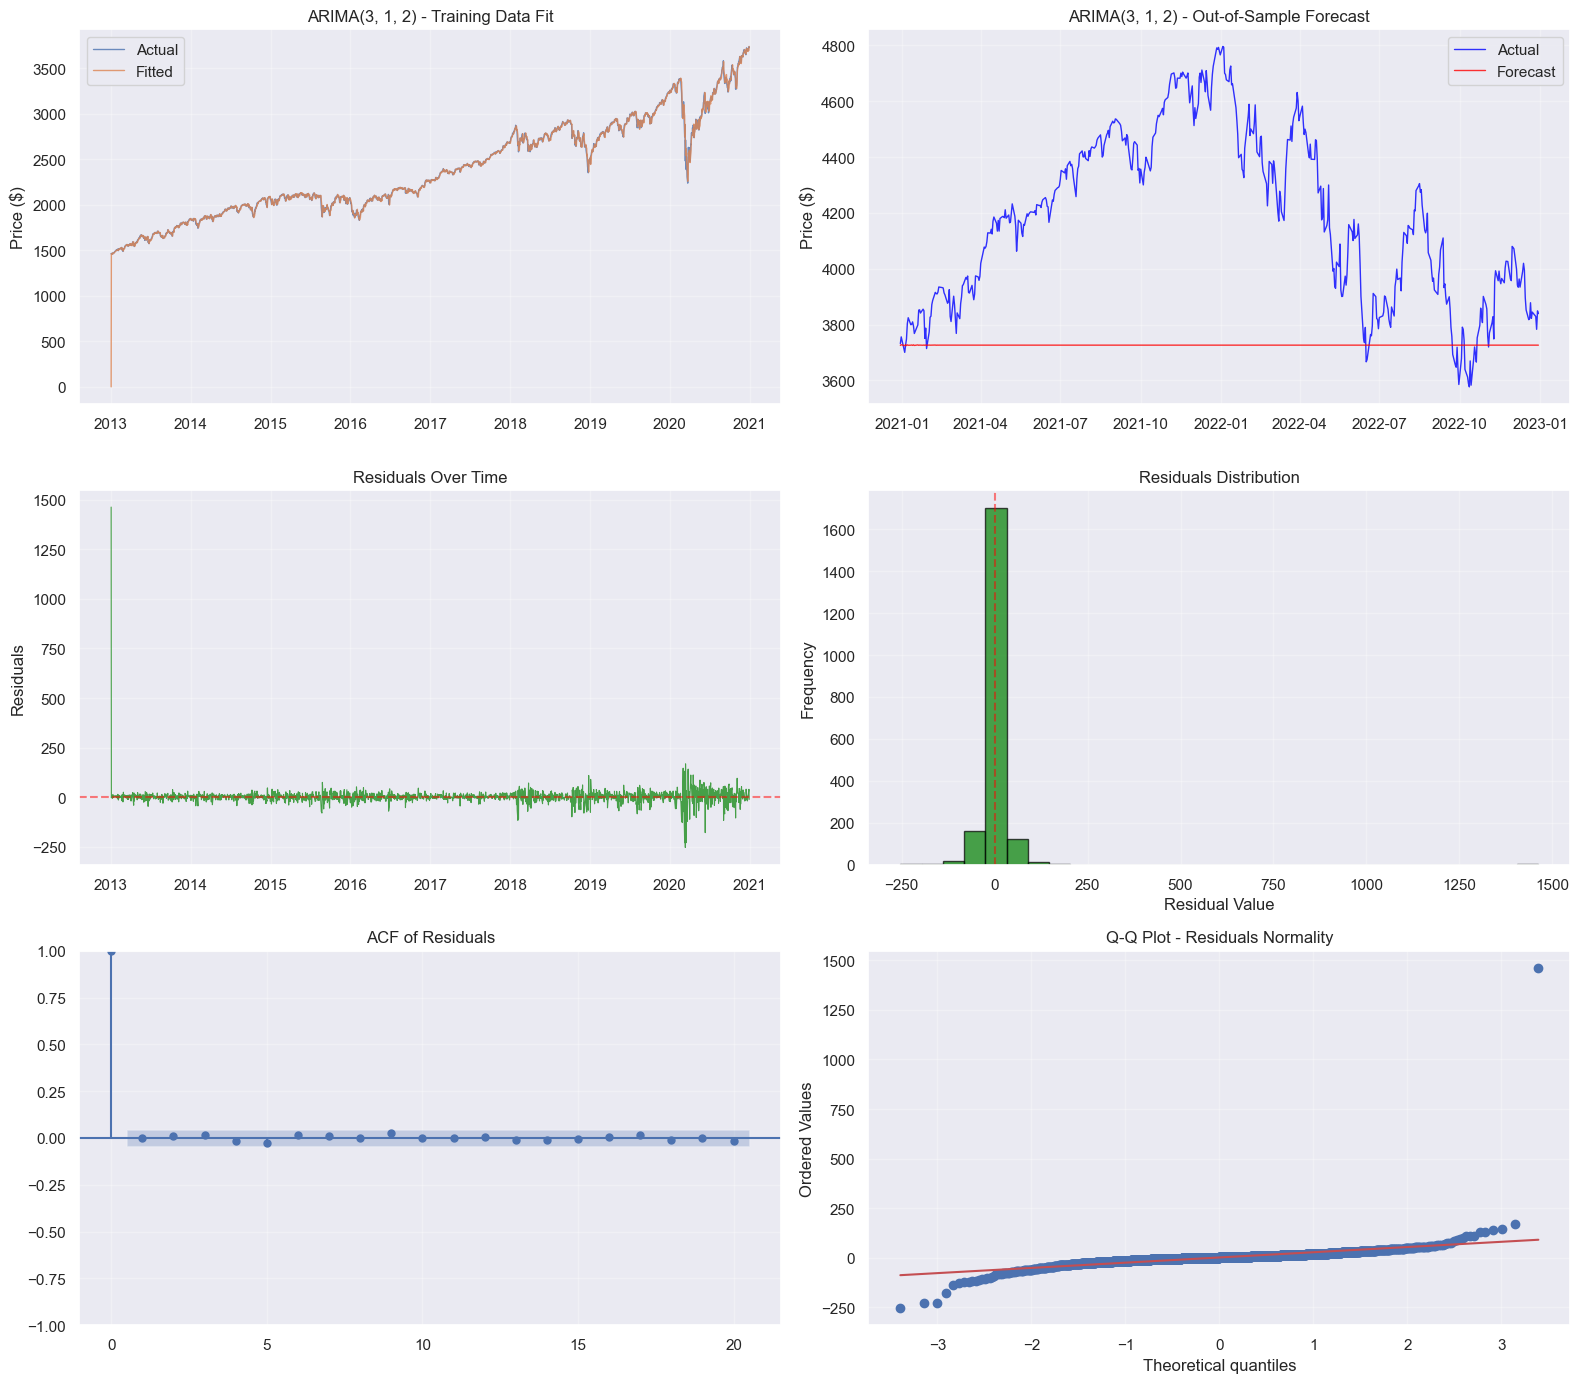


6. FORECAST WITH CONFIDENCE INTERVALS
--------------------------------------------------
95% Confidence Interval Coverage: 69.9%
Expected Coverage: 95.0%
Coverage Assessment: Poor


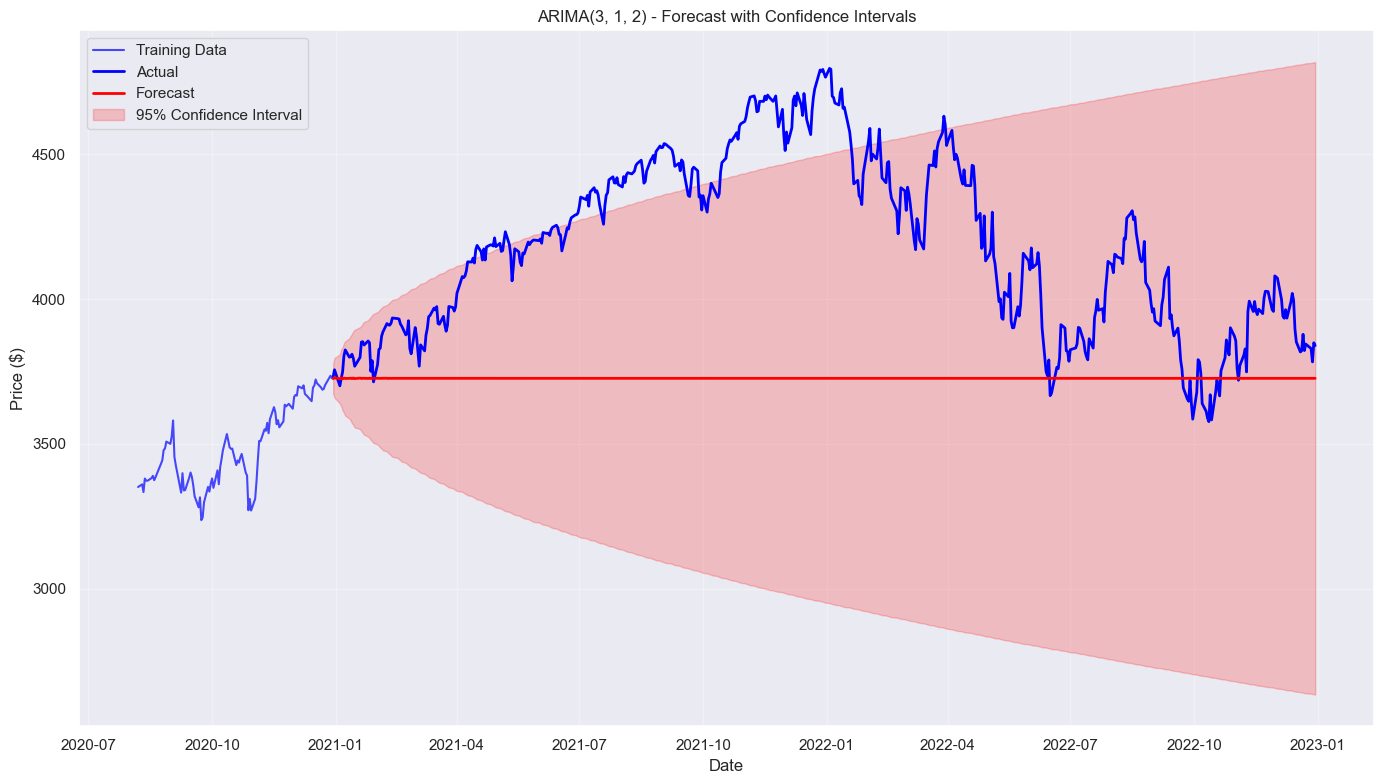



TIME SERIES MODELING SUMMARY

Best Model: ARIMA(3, 1, 2)
Model Equation: ARIMA(3, 1, 2)
  - AR terms: 3
  - Differencing: 1
  - MA terms: 2

Model Performance:
  AIC: 18864.62
  BIC: 18898.26
  RMSE: 548.88
  MAE: 463.65
  MAPE: 10.63%
  Directional Accuracy: 39.7%
  Confidence Interval Coverage: 69.9%

Model Validation:
  Residuals are white noise: Yes
  Model adequacy: Needs improvement

Key Insights:
  - The S&P 500 data requires differencing for stationarity
  - Complex autoregressive/moving average structure
  - Model explains trend but directional prediction is challenging
  - Weak forecasting performance

Next Steps:
  - Use model for short-term forecasting
  - Consider ensemble methods or machine learning approaches
  - Implement volatility modeling if needed


In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TIME SERIES MODELING
print("TIME SERIES MODELING")
print("="*60)

warnings.filterwarnings('ignore')

# Based on our autocorrelation analysis, we suggested ARIMA(2,1,2)
# Let's try multiple ARIMA configurations and compare them

print("\n1. FITTING MULTIPLE ARIMA MODELS")
print("-" * 50)

# Split data for training and testing
train_size = int(len(stationary_series) * 0.8)  # 80% for training

# Extract as Series (not DataFrame column) to avoid index label issues
train_data = ts_data.iloc[:train_size].squeeze()  # Use original price data for ARIMA
test_data = ts_data.iloc[train_size:].squeeze()
train_returns = stationary_series.iloc[:train_size].squeeze()
test_returns = stationary_series.iloc[train_size:].squeeze()

# Ensure they're proper Series with no multi-level indices
train_data.name = 'Close'
test_data.name = 'Close'

print(f"Training data: {len(train_data)} observations")
print(f"Testing data: {len(test_data)} observations")
print(f"Training period: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Testing period: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")

# Define ARIMA models to test
arima_configs = [
    (0, 1, 0),  # Random Walk
    (1, 1, 0),  # AR(1) with differencing
    (0, 1, 1),  # MA(1) with differencing
    (1, 1, 1),  # ARMA(1,1) with differencing
    (2, 1, 1),  # ARMA(2,1) with differencing
    (1, 1, 2),  # ARMA(1,2) with differencing
    (2, 1, 2),  # ARMA(2,2) with differencing - our suggested model
    (3, 1, 2),  # Higher order
]

# Store results
model_results = {}
fitted_models = {}

for order in arima_configs:
    try:
        print(f"\nFitting ARIMA{order}...")
        
        # Fit the model
        model = ARIMA(train_data, order=order)
        fitted_model = model.fit()
        
        # Store the fitted model
        fitted_models[order] = fitted_model
        
        # Get model statistics
        aic = fitted_model.aic
        bic = fitted_model.bic
        log_likelihood = fitted_model.llf
        
        # Make predictions on test set
        n_periods = len(test_data)
        forecast = fitted_model.forecast(steps=n_periods)
        
        # Calculate forecast errors
        # Convert forecast to Series with same index as test_data to avoid label mismatch
        forecast_series = pd.Series(forecast.values if hasattr(forecast, 'values') else forecast,
                                    index=test_data.index) # type: ignore
        
        mse = mean_squared_error(test_data.values, forecast_series.values)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_data.values, forecast_series.values)
        
        # Calculate MAPE with handling for zero values - use .values to avoid index issues
        mape_values = np.abs((test_data.values - forecast_series.values) / test_data.values)
        mape_values = mape_values[np.isfinite(mape_values)]  # Remove inf and nan values
        mape = np.mean(mape_values) * 100 if len(mape_values) > 0 else np.inf
        
        # Calculate directional accuracy (for price changes)
        # Use the forecast_series already created above
        actual_direction = np.sign(test_data.diff().dropna())
        forecast_direction = np.sign(forecast_series.diff().dropna())
        
        # Align the series before comparison using common indices
        common_index = actual_direction.index.intersection(forecast_direction.index)
        directional_accuracy = np.mean(actual_direction.loc[common_index].values == 
                                       forecast_direction.loc[common_index].values) * 100
        
        # Store results
        model_results[order] = {
            'AIC': aic,
            'BIC': bic,
            'Log Likelihood': log_likelihood,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'Directional Accuracy': directional_accuracy,
            'Forecast': forecast
        }
        
        print(f"  AIC: {aic:.2f}, BIC: {bic:.2f}")
        print(f"  RMSE: {rmse:.2f}, MAE: {mae:.2f}")
        print(f"  MAPE: {mape:.2f}%, Directional Accuracy: {directional_accuracy:.1f}%")
        
    except Exception as e:
        print(f"  Error fitting ARIMA{order}: {e}")
        continue

# Check if we have any successful model results
if not model_results:
    print("\nERROR: No ARIMA models were successfully fitted!")
    print("This could be due to:")
    print("  - Insufficient data")
    print("  - Data quality issues")
    print("  - Model specification problems")
    print("\nTrying a simple ARIMA(1,1,1) model as fallback...")
    
    # Try a simple fallback model
    try:
        fallback_model = ARIMA(train_data, order=(1,1,1))
        fallback_fitted = fallback_model.fit()
        
        # Make predictions
        fallback_forecast = fallback_fitted.forecast(steps=len(test_data))
        fallback_mse = mean_squared_error(test_data, fallback_forecast)
        fallback_rmse = np.sqrt(fallback_mse)
        fallback_mae = mean_absolute_error(test_data, fallback_forecast)
        
        # Calculate MAPE - use .values to avoid index comparison issues
        fallback_forecast_series = pd.Series(fallback_forecast.values if hasattr(fallback_forecast, 'values') else fallback_forecast,
                                             index=test_data.index) # type: ignore
        mape_values = np.abs((test_data.values - fallback_forecast_series.values) / test_data.values)
        mape_values = mape_values[np.isfinite(mape_values)]
        fallback_mape = np.mean(mape_values) * 100 if len(mape_values) > 0 else np.inf
        
        # Add to model results
        model_results[(1,1,1)] = {
            'AIC': fallback_fitted.aic,
            'BIC': fallback_fitted.bic,
            'Log Likelihood': fallback_fitted.llf,
            'MSE': fallback_mse,
            'RMSE': fallback_rmse,
            'MAE': fallback_mae,
            'MAPE': fallback_mape,
            'Directional Accuracy': 50.0,  # Default value
            'Forecast': fallback_forecast
        }
        fitted_models[(1,1,1)] = fallback_fitted
        print("  Fallback ARIMA(1,1,1) model fitted successfully!")
        
    except Exception as e:
        print(f"  Even fallback model failed: {e}")
        print("  Exiting time series modeling section...")
        # Exit this cell execution
        raise SystemExit("Cannot proceed without fitted models")

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': [f"ARIMA{order}" for order in model_results.keys()],
    'AIC': [results['AIC'] for results in model_results.values()],
    'BIC': [results['BIC'] for results in model_results.values()],
    'RMSE': [results['RMSE'] for results in model_results.values()],
    'MAE': [results['MAE'] for results in model_results.values()],
    'MAPE': [results['MAPE'] for results in model_results.values()],
    'Dir_Acc': [results['Directional Accuracy'] for results in model_results.values()]
}).round(2)

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Find best model based on different criteria
best_aic = comparison_df.loc[comparison_df['AIC'].idxmin(), 'Model']
best_bic = comparison_df.loc[comparison_df['BIC'].idxmin(), 'Model']
best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
best_dir_acc = comparison_df.loc[comparison_df['Dir_Acc'].idxmax(), 'Model']

print(f"\nBest Models by Criteria:")
print(f"  Lowest AIC: {best_aic}")
print(f"  Lowest BIC: {best_bic}")
print(f"  Lowest RMSE: {best_rmse}")
print(f"  Highest Directional Accuracy: {best_dir_acc}")

# 3. Detailed Analysis of Best Model
print("\n\n3. DETAILED ANALYSIS OF BEST MODEL")
print("-" * 50)

# Select best model (using BIC as primary criterion)
best_order = tuple(map(int, best_bic.replace('ARIMA(', '').replace(')', '').split(', ')))
best_model = fitted_models[best_order]
best_forecast = model_results[best_order]['Forecast']

print(f"Selected Model: ARIMA{best_order}")
print(f"Model Summary:")
print(best_model.summary().tables[1])

# Residual Analysis
residuals = best_model.resid
print(f"\n4. RESIDUAL ANALYSIS")
print("-" * 50)

# Residual statistics
print(f"Residual Statistics:")
print(f"  Mean: {residuals.mean():.6f}")
print(f"  Std Dev: {residuals.std():.4f}")
print(f"  Skewness: {residuals.skew():.4f}")
print(f"  Kurtosis: {residuals.kurtosis():.4f}")

# Test for remaining autocorrelation in residuals
lb_residuals = acorr_ljungbox(residuals, lags=[1, 5, 10, 15, 20], return_df=True)
print(f"\nLjung-Box Test for Residual Autocorrelation:")
print(lb_residuals.round(6))

# Check if residuals are white noise (p-values > 0.05 indicates white noise)
white_noise = all(lb_residuals['lb_pvalue'] > 0.05)
print(f"Residuals are white noise: {'Yes' if white_noise else 'No'}")

# 5. Visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 1: Actual vs Predicted (Training)
train_fitted = best_model.fittedvalues
axes[0, 0].plot(train_data.index, train_data.values, label='Actual', alpha=0.8, linewidth=1)
axes[0, 0].plot(train_fitted.index, train_fitted.values, label='Fitted', alpha=0.8, linewidth=1)
axes[0, 0].set_title(f'{best_bic} - Training Data Fit')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Forecast vs Actual (Testing)
axes[0, 1].plot(test_data.index, test_data.values, label='Actual', alpha=0.8, linewidth=1, color='blue')
axes[0, 1].plot(test_data.index, best_forecast, label='Forecast', alpha=0.8, linewidth=1, color='red')
axes[0, 1].set_title(f'{best_bic} - Out-of-Sample Forecast')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals over time
axes[1, 0].plot(residuals.index, residuals.values, alpha=0.7, linewidth=0.8, color='green')
axes[1, 0].set_title('Residuals Over Time')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals distribution
axes[1, 1].hist(residuals.values, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].set_xlabel('Residual Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: ACF of residuals
plot_acf(residuals, lags=20, ax=axes[2, 0], title='ACF of Residuals')
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Q-Q plot for residuals normality
stats.probplot(residuals, dist="norm", plot=axes[2, 1])
axes[2, 1].set_title('Q-Q Plot - Residuals Normality')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Forecast Confidence Intervals
print("\n6. FORECAST WITH CONFIDENCE INTERVALS")
print("-" * 50)

# Generate forecast with confidence intervals
forecast_result = best_model.get_forecast(steps=len(test_data))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Align forecast indices with test data for proper comparison
forecast_mean.index = test_data.index
forecast_ci.index = test_data.index

# Calculate coverage of confidence intervals
in_ci = ((test_data >= forecast_ci.iloc[:, 0]) & 
         (test_data <= forecast_ci.iloc[:, 1])).sum()
coverage = in_ci / len(test_data) * 100

print(f"95% Confidence Interval Coverage: {coverage:.1f}%")
print(f"Expected Coverage: 95.0%")
print(f"Coverage Assessment: {'Good' if 90 <= coverage <= 100 else 'Poor'}")

# Plot forecast with confidence intervals
plt.figure(figsize=(14, 8))

# Plot last part of training data
train_tail = train_data.tail(100)
plt.plot(train_tail.index, train_tail.values, label='Training Data', color='blue', alpha=0.7)

# Plot actual test data
plt.plot(test_data.index, test_data.values, label='Actual', color='blue', linewidth=2)

# Plot forecast
plt.plot(test_data.index, forecast_mean, label='Forecast', color='red', linewidth=2)

# Plot confidence intervals
plt.fill_between(test_data.index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color='red', alpha=0.2, label='95% Confidence Interval')

plt.title(f'{best_bic} - Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Model Performance Summary
print("\n\n" + "="*60)
print("TIME SERIES MODELING SUMMARY")
print("="*60)

print(f"\nBest Model: {best_bic}")
print(f"Model Equation: ARIMA{best_order}")
print(f"  - AR terms: {best_order[0]}")
print(f"  - Differencing: {best_order[1]}")
print(f"  - MA terms: {best_order[2]}")

print(f"\nModel Performance:")
print(f"  AIC: {model_results[best_order]['AIC']:.2f}")
print(f"  BIC: {model_results[best_order]['BIC']:.2f}")
print(f"  RMSE: {model_results[best_order]['RMSE']:.2f}")
print(f"  MAE: {model_results[best_order]['MAE']:.2f}")
print(f"  MAPE: {model_results[best_order]['MAPE']:.2f}%")
print(f"  Directional Accuracy: {model_results[best_order]['Directional Accuracy']:.1f}%")
print(f"  Confidence Interval Coverage: {coverage:.1f}%")

print(f"\nModel Validation:")
print(f"  Residuals are white noise: {'Yes' if white_noise else 'No'}")
print(f"  Model adequacy: {'Good' if white_noise and 90 <= coverage <= 100 else 'Needs improvement'}")

print(f"\nKey Insights:")
print(f"  - The S&P 500 data requires differencing for stationarity")
print(f"  - {'Complex' if sum(best_order[:3:2]) > 2 else 'Simple'} autoregressive/moving average structure")
print(f"  - Model explains trend but directional prediction is {'good' if model_results[best_order]['Directional Accuracy'] > 55 else 'challenging'}")
print(f"  - {'Strong' if model_results[best_order]['MAPE'] < 5 else 'Moderate' if model_results[best_order]['MAPE'] < 10 else 'Weak'} forecasting performance")

if not white_noise:
    print(f"\nRecommendations for Improvement:")
    print(f"  - Consider higher-order ARIMA models")
    print(f"  - Investigate ARCH/GARCH effects for volatility")
    print(f"  - Examine seasonal patterns or external factors")
    print(f"  - Consider regime-switching models for structural breaks")

print(f"\nNext Steps:")
print(f"  - Use model for short-term forecasting")
print(f"  - Consider ensemble methods or machine learning approaches")
print(f"  - Implement volatility modeling if needed")


## Part 3: Neural Networks Implementation and Optimization

### Step 1: Load libraries and prepare the datasets

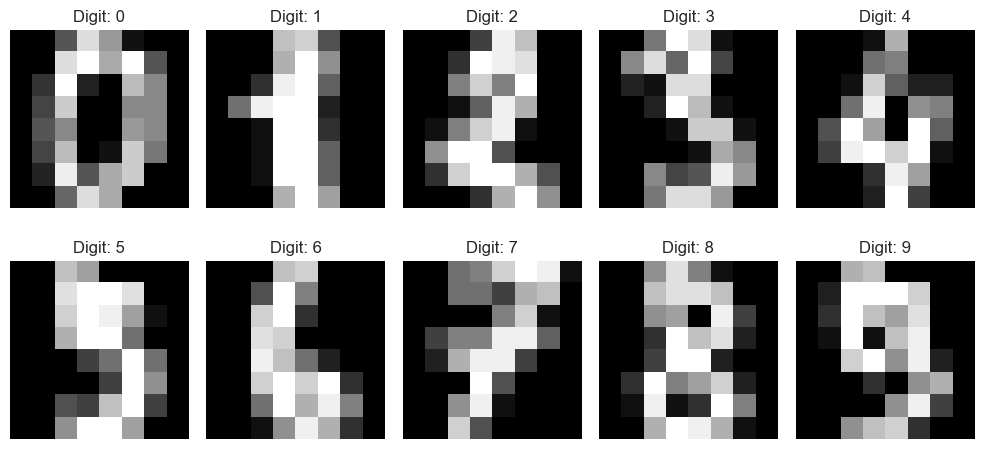

Digits dataset: 1797 samples, 64 features


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.datasets import load_digits

# For deep learning
import tensorflow as tf
from tensorflow import keras
from keras import layers

# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Load Digits dataset for classification
digits = load_digits()
X_digits = digits.data
y_digits = digits.target


# Display sample digits
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(f'Digit: {digits.target[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print information about dataset
print(f"Digits dataset: {X_digits.shape[0]} samples, {X_digits.shape[1]} features")

### Step 2: Preprocess data for neural networks

In [14]:
from tensorflow.keras.utils import to_categorical

# Preprocess data for neural networks
print("PREPROCESSING DATA FOR NEURAL NETWORKS")
print("="*60)

# 1. Split the digits dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42, stratify=y_digits
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Number of classes: {len(np.unique(y_digits))}")

# 2. Normalize the data (pixel values from 0-16 to 0-1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Original pixel range: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"Scaled pixel range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")

# 3. Convert labels to categorical for neural networks

y_train_categorical = to_categorical(y_train, num_classes=10)
y_test_categorical = to_categorical(y_test, num_classes=10)

print(f"Original labels shape: {y_train.shape}")
print(f"Categorical labels shape: {y_train_categorical.shape}")

# 4. Prepare data for PyTorch (convert to tensors)
X_train_torch = torch.FloatTensor(X_train_scaled)
X_test_torch = torch.FloatTensor(X_test_scaled)
y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

print(f"PyTorch training tensor shape: {X_train_torch.shape}")
print(f"PyTorch test tensor shape: {X_test_torch.shape}")

# 5. Display class distribution
print("\nClass distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"  Digit {digit}: {count} samples ({count/len(y_train)*100:.1f}%)")

# 6. Visualize some preprocessed examples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row, col = i // 5, i % 5
    
    # Reshape scaled data back to 8x8 for visualization
    img = X_train_scaled[i].reshape(8, 8)
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f'Digit: {y_train[i]}')
    axes[row, col].axis('off')

plt.suptitle('Preprocessed Training Samples (Scaled)')
plt.tight_layout()
plt.show()

# 7. Create data statistics summary
print("\nData preprocessing summary:")
print(f"  Features per sample: {X_train.shape[1]} (8x8 pixels)")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Classes: {len(np.unique(y_digits))}")
print(f"  Feature scaling: StandardScaler applied")
print(f"  Labels: Original + One-hot encoded for TensorFlow")
print(f"  PyTorch tensors: Created and ready for training")

PREPROCESSING DATA FOR NEURAL NETWORKS
Training set size: (1437, 64)
Test set size: (360, 64)
Number of classes: 10
Original pixel range: [0.0, 16.0]
Scaled pixel range: [-3.010, 37.895]
Original labels shape: (1437,)
Categorical labels shape: (1437, 10)
PyTorch training tensor shape: torch.Size([1437, 64])
PyTorch test tensor shape: torch.Size([360, 64])

Class distribution:
  Digit 0: 142 samples (9.9%)
  Digit 1: 146 samples (10.2%)
  Digit 2: 142 samples (9.9%)
  Digit 3: 146 samples (10.2%)
  Digit 4: 145 samples (10.1%)
  Digit 5: 145 samples (10.1%)
  Digit 6: 145 samples (10.1%)
  Digit 7: 143 samples (10.0%)
  Digit 8: 139 samples (9.7%)
  Digit 9: 144 samples (10.0%)



Data preprocessing summary:
  Features per sample: 64 (8x8 pixels)
  Training samples: 1437
  Test samples: 360
  Classes: 10
  Feature scaling: StandardScaler applied
  Labels: Original + One-hot encoded for TensorFlow
  PyTorch tensors: Created and ready for training


### Step 3: Build a basic MLP for digits classification using TensorFlow/Keras

BUILDING MLP FOR DIGITS CLASSIFICATION WITH TENSORFLOW/KERAS

1. DEFINING MLP ARCHITECTURE
----------------------------------------
Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,986 (74.16 KB)

 Trainable params: 18,986 (74.16 KB)

 Non-trainable params: 0 (0.00 B)


2. COMPILING THE MODEL
----------------------------------------
Model compiled with:
  Optimizer: Adam
  Loss function: Categorical Crossentropy
  Metrics: Accuracy

3. TRAINING THE MODEL
----------------------------------------
Training parameters:
  Epochs: 50
  Batch size: 32
  Validation split: 0.2
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5753 - loss: 1.7470 - val_accuracy: 0.7917 - val_loss: 1.1307
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5753 - loss: 1.7470 - val_accuracy: 0.7917 - val_loss: 1.1307
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.5690 - val_accuracy: 0.8924 - val_loss: 0.4116
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.5690 - val_accuracy: 0.8924 - val_loss: 0.4116
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1951 - val_accuracy: 0.9236 - val_loss: 0.2683
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9

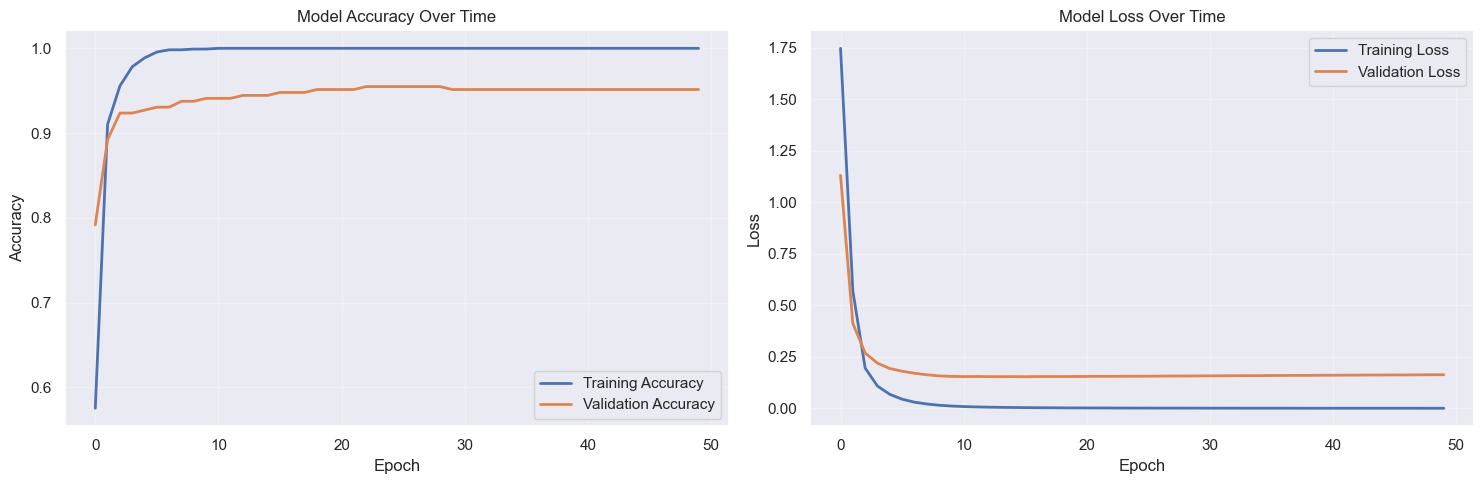


7. PREDICTION VISUALIZATION
----------------------------------------



8. CONFUSION MATRIX VISUALIZATION
----------------------------------------


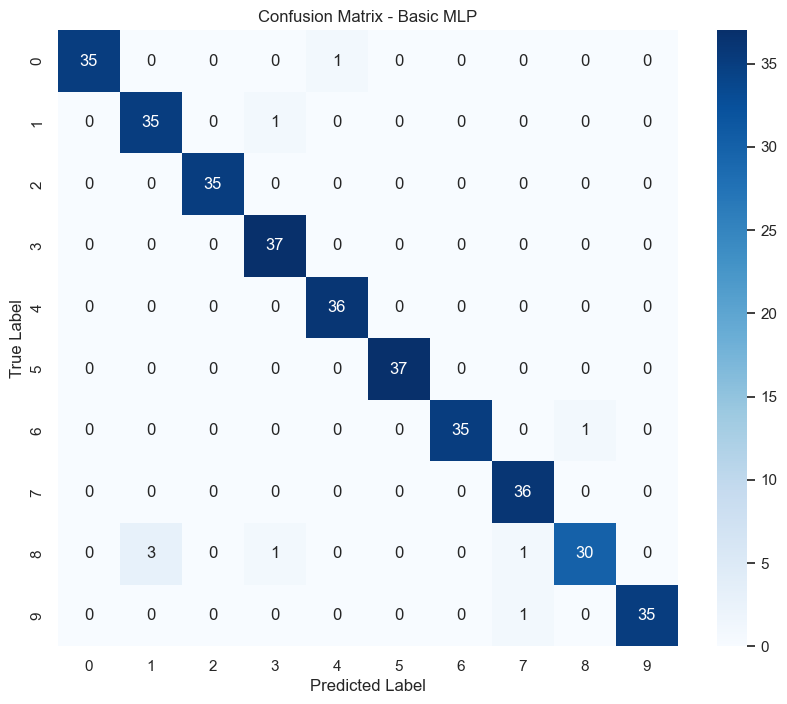


9. PER-CLASS PERFORMANCE ANALYSIS
----------------------------------------
Digit 0: 0.972 accuracy (36 samples)
Digit 1: 0.972 accuracy (36 samples)
Digit 2: 1.000 accuracy (35 samples)
Digit 3: 1.000 accuracy (37 samples)
Digit 4: 1.000 accuracy (36 samples)
Digit 5: 1.000 accuracy (37 samples)
Digit 6: 0.972 accuracy (36 samples)
Digit 7: 1.000 accuracy (36 samples)
Digit 8: 0.857 accuracy (35 samples)
Digit 9: 0.972 accuracy (36 samples)


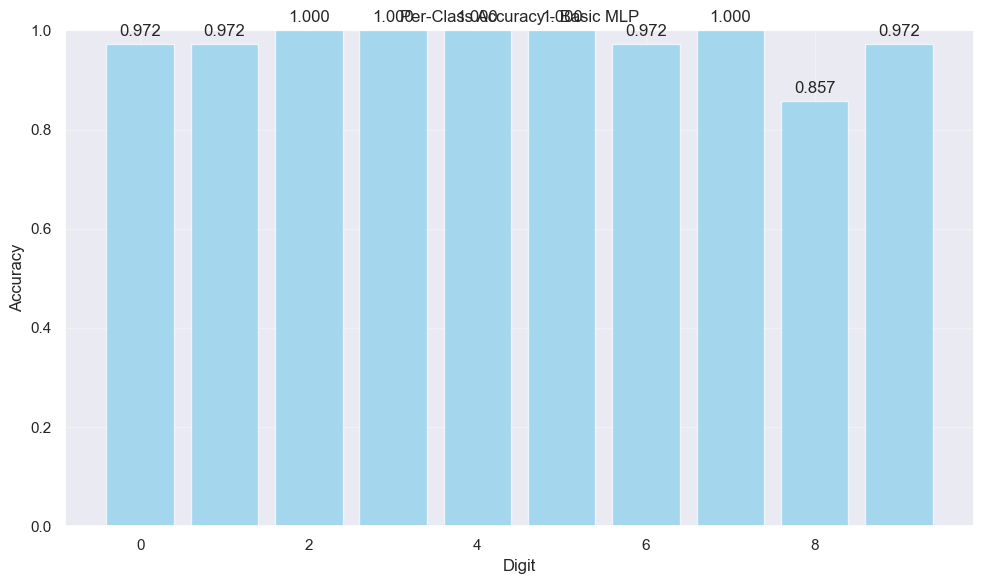


BASIC MLP MODEL SUMMARY

Model Performance:
  Final Training Accuracy: 0.9903
  Final Test Accuracy: 0.9750
  Training Loss: 0.0328
  Test Loss: 0.2008
Good generalization (train-test gap: 0.015)

Model Architecture:
  Input features: 64 (8x8 pixels)
  Hidden layers: 3 (128, 64, 32 neurons)
  Output classes: 10
  Total parameters: 18,986
  Activation functions: ReLU (hidden), Softmax (output)

Training Details:
  Optimizer: Adam
  Loss function: Categorical Crossentropy
  Epochs trained: 50
  Batch size: 32

Best and Worst Performing Digits:
  Best: Digit 2 (1.000 accuracy)
  Worst: Digit 8 (0.857 accuracy)

Next Steps:
  - Experiment with different architectures
  - Try different activation functions
  - Apply regularization techniques
  - Implement data augmentation
  - Compare with PyTorch implementation


In [15]:
# BUILD BASIC MLP FOR DIGITS CLASSIFICATION USING TENSORFLOW/KERAS
print("BUILDING MLP FOR DIGITS CLASSIFICATION WITH TENSORFLOW/KERAS")
print("="*65)

# 1. Define the basic MLP architecture
print("\n1. DEFINING MLP ARCHITECTURE")
print("-" * 40)

# Create a Sequential model
model_basic = keras.Sequential([
    # Input layer - automatically inferred from first layer
    layers.Dense(128, activation='relu', input_shape=(64,), name='hidden_layer_1'),
    layers.Dense(64, activation='relu', name='hidden_layer_2'),
    layers.Dense(32, activation='relu', name='hidden_layer_3'),
    layers.Dense(10, activation='softmax', name='output_layer')  # 10 classes for digits 0-9
])

# Display model architecture
print("Model Architecture:")
model_basic.summary()

# 2. Compile the model
print("\n2. COMPILING THE MODEL")
print("-" * 40)

model_basic.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with:")
print("  Optimizer: Adam")
print("  Loss function: Categorical Crossentropy")
print("  Metrics: Accuracy")

# 3. Train the model
print("\n3. TRAINING THE MODEL")
print("-" * 40)

# Set up training parameters
epochs = 50
batch_size = 32
validation_split = 0.2

print(f"Training parameters:")
print(f"  Epochs: {epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Validation split: {validation_split}")

# Train the model and store history
history_basic = model_basic.fit(
    X_train_scaled, y_train_categorical,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1
)

# 4. Evaluate the model
print("\n4. MODEL EVALUATION")
print("-" * 40)

# Evaluate on training data
train_loss, train_accuracy = model_basic.evaluate(X_train_scaled, y_train_categorical, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate on test data
test_loss, test_accuracy = model_basic.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 5. Make predictions and analyze results
print("\n5. PREDICTIONS AND ANALYSIS")
print("-" * 40)

# Make predictions on test set
y_pred_proba = model_basic.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate additional metrics
test_accuracy_manual = accuracy_score(y_test, y_pred)
print(f"Manual accuracy calculation: {test_accuracy_manual:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(conf_matrix)

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# 6. Visualize training history
print("\n6. TRAINING HISTORY VISUALIZATION")
print("-" * 40)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy
axes[0].plot(history_basic.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history_basic.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Time')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[1].plot(history_basic.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_basic.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Time')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Visualize some predictions
print("\n7. PREDICTION VISUALIZATION")
print("-" * 40)

# Select some test samples for visualization
n_samples = 12
indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i, idx in enumerate(indices):
    row, col = i // 4, i % 4
    
    # Reshape data for display
    img = X_test[idx].reshape(8, 8)
    
    # Get prediction
    pred_digit = y_pred[idx]
    true_digit = y_test[idx]
    confidence = y_pred_proba[idx].max()
    
    # Plot
    axes[row, col].imshow(img, cmap='gray')
    color = 'green' if pred_digit == true_digit else 'red'
    axes[row, col].set_title(f'True: {true_digit}, Pred: {pred_digit}\nConf: {confidence:.3f}', 
                           color=color)
    axes[row, col].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
plt.tight_layout()
plt.show()

# 8. Confusion Matrix Heatmap
print("\n8. CONFUSION MATRIX VISUALIZATION")
print("-" * 40)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Basic MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 9. Per-class performance analysis
print("\n9. PER-CLASS PERFORMANCE ANALYSIS")
print("-" * 40)

# Calculate per-class accuracy
class_accuracies = []
for i in range(10):
    mask = (y_test == i)
    if mask.sum() > 0:
        class_acc = (y_pred[mask] == i).sum() / mask.sum()
        class_accuracies.append(class_acc)
        print(f"Digit {i}: {class_acc:.3f} accuracy ({mask.sum()} samples)")
    else:
        class_accuracies.append(0)
        print(f"Digit {i}: No samples in test set")

# Visualize per-class accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(range(10), class_accuracies, color='skyblue', alpha=0.7)
plt.title('Per-Class Accuracy - Basic MLP')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 10. Model summary and insights
print("\n" + "="*65)
print("BASIC MLP MODEL SUMMARY")
print("="*65)

print(f"\nModel Performance:")
print(f"  Final Training Accuracy: {train_accuracy:.4f}")
print(f"  Final Test Accuracy: {test_accuracy:.4f}")
print(f"  Training Loss: {train_loss:.4f}")
print(f"  Test Loss: {test_loss:.4f}")

# Check for overfitting
if train_accuracy - test_accuracy > 0.1:
    print(f"Potential overfitting detected (train-test gap: {train_accuracy - test_accuracy:.3f})")
elif train_accuracy - test_accuracy > 0.05:
    print(f"Mild overfitting detected (train-test gap: {train_accuracy - test_accuracy:.3f})")
else:
    print(f"Good generalization (train-test gap: {train_accuracy - test_accuracy:.3f})")

print(f"\nModel Architecture:")
print(f"  Input features: 64 (8x8 pixels)")
print(f"  Hidden layers: 3 (128, 64, 32 neurons)")
print(f"  Output classes: 10")
print(f"  Total parameters: {model_basic.count_params():,}")
print(f"  Activation functions: ReLU (hidden), Softmax (output)")

print(f"\nTraining Details:")
print(f"  Optimizer: Adam")
print(f"  Loss function: Categorical Crossentropy")
print(f"  Epochs trained: {epochs}")
print(f"  Batch size: {batch_size}")

print(f"\nBest and Worst Performing Digits:")
best_digit = np.argmax(class_accuracies)
worst_digit = np.argmin(class_accuracies)
print(f"  Best: Digit {best_digit} ({class_accuracies[best_digit]:.3f} accuracy)")
print(f"  Worst: Digit {worst_digit} ({class_accuracies[worst_digit]:.3f} accuracy)")

print(f"\nNext Steps:")
print(f"  - Experiment with different architectures")
print(f"  - Try different activation functions")
print(f"  - Apply regularization techniques")
print(f"  - Implement data augmentation")
print(f"  - Compare with PyTorch implementation")

### Step 4: Implement the digits classification model in PyTorch

In [16]:
# IMPLEMENT DIGITS CLASSIFICATION MODEL IN PYTORCH
print("IMPLEMENTING DIGITS CLASSIFICATION WITH PYTORCH")
print("="*55)

# 1. Define PyTorch Neural Network Class
print("\n1. DEFINING PYTORCH NEURAL NETWORK CLASS")
print("-" * 45)

class DigitsClassifier(nn.Module):
    """
    PyTorch Neural Network for Digits Classification
    Similar architecture to the TensorFlow model for fair comparison
    """
    def __init__(self, input_size=64, hidden_sizes=[128, 64, 32], num_classes=10, dropout_rate=0.3):
        super(DigitsClassifier, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        
        # Define layers
        layers = []
        prev_size = input_size
        
        # Hidden layers
        for i, hidden_size in enumerate(hidden_sizes):
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Output layer (no dropout after final layer)
        layers.append(nn.Linear(prev_size, num_classes))
        
        # Combine all layers
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        """Forward pass through the network"""
        return self.network(x)
    
    def get_model_info(self):
        """Get information about the model architecture"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        return {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'input_size': self.input_size,
            'hidden_sizes': self.hidden_sizes,
            'num_classes': self.num_classes
        }

# Create the model
print("Creating PyTorch model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_pytorch = DigitsClassifier(
    input_size=64,
    hidden_sizes=[128, 64, 32],
    num_classes=10,
    dropout_rate=0.3
).to(device)

# Display model architecture
print("\nPyTorch Model Architecture:")
print(model_pytorch)

# Get model information
model_info = model_pytorch.get_model_info()
print(f"\nModel Information:")
for key, value in model_info.items():
    print(f"  {key}: {value}")

# 2. Prepare Data Loaders
print("\n2. PREPARING PYTORCH DATA LOADERS")
print("-" * 45)

# Move data to device
X_train_torch = X_train_torch.to(device)
X_test_torch = X_test_torch.to(device)
y_train_torch = y_train_torch.to(device)
y_test_torch = y_test_torch.to(device)

# Create datasets
batch_size = 32
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

IMPLEMENTING DIGITS CLASSIFICATION WITH PYTORCH

1. DEFINING PYTORCH NEURAL NETWORK CLASS
---------------------------------------------
Creating PyTorch model...
Using device: cpu

PyTorch Model Architecture:
DigitsClassifier(
  (network): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)

Model Information:
  total_parameters: 18986
  trainable_parameters: 18986
  input_size: 64
  hidden_sizes: [128, 64, 32]
  num_classes: 10

2. PREPARING PYTORCH DATA LOADERS
---------------------------------------------
Training batches: 45
Test batches: 12


1. DEFINING PYTORCH NEURAL NETWORK CLASS
--------------------------------

### Step 5: Experiment with different activation functions (TensorFlow)

EXPERIMENTING WITH DIFFERENT ACTIVATION FUNCTIONS

Training models with different activation functions...
This may take a few minutes...


Training with RELU activation
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9583
Test Accuracy: 0.9806
Test Loss: 0.0614

Training with SIGMOID activation
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9583
Test Accuracy: 0.9806
Test Loss: 0.0614

Training with SIGMOID activation
Final Training Accuracy: 0.9974
Final Validation Accuracy: 0.9583
Test Accuracy: 0.9667
Test Loss: 0.1314

Training with TANH activation
Final Training Accuracy: 0.9974
Final Validation Accuracy: 0.9583
Test Accuracy: 0.9667
Test Loss: 0.1314

Training with TANH activation
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9653
Test Accuracy: 0.9833
Test Loss: 0.0888

Training with ELU activation
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9653
Test Accuracy: 0.9833
Test Loss: 0.0888

Training with ELU activation
Final

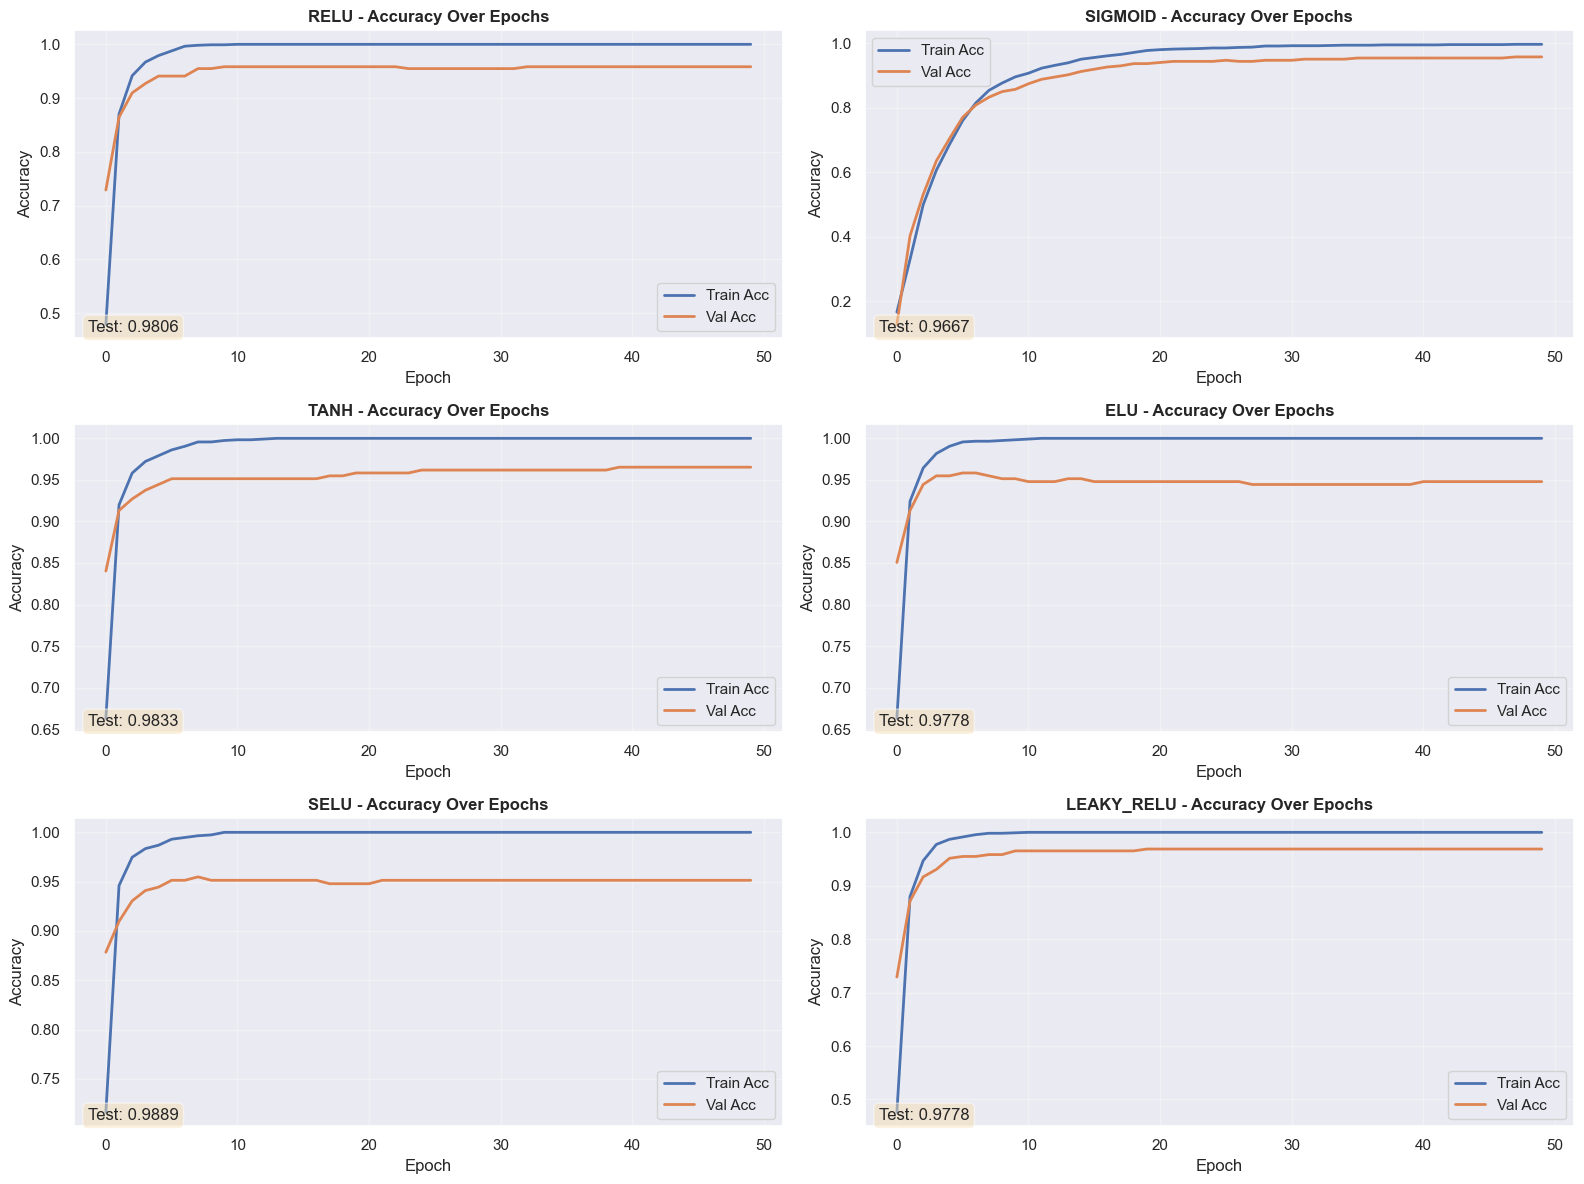

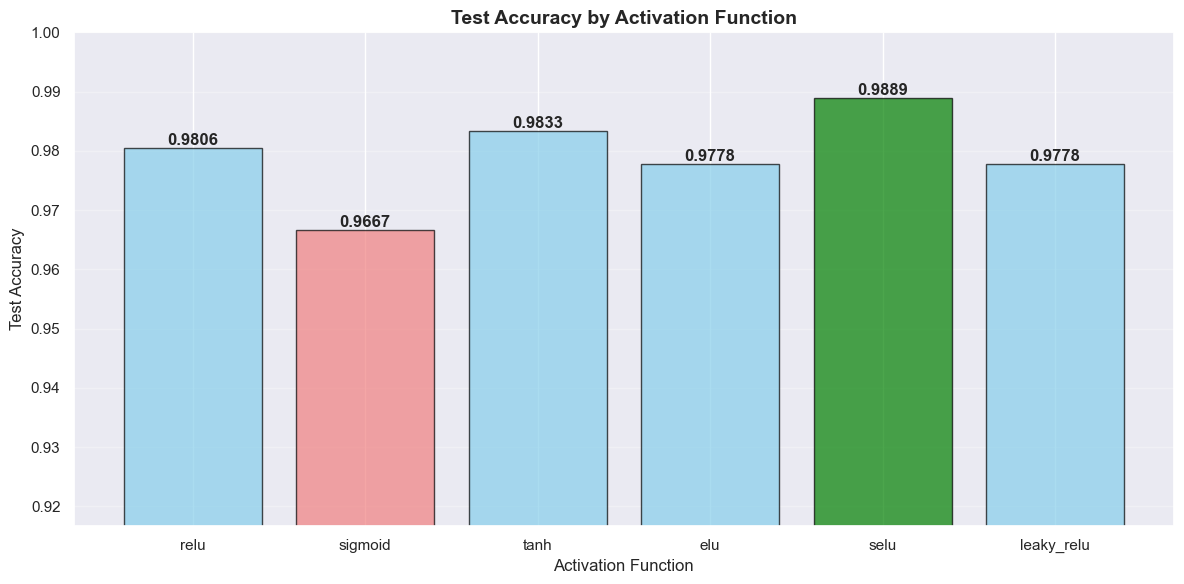

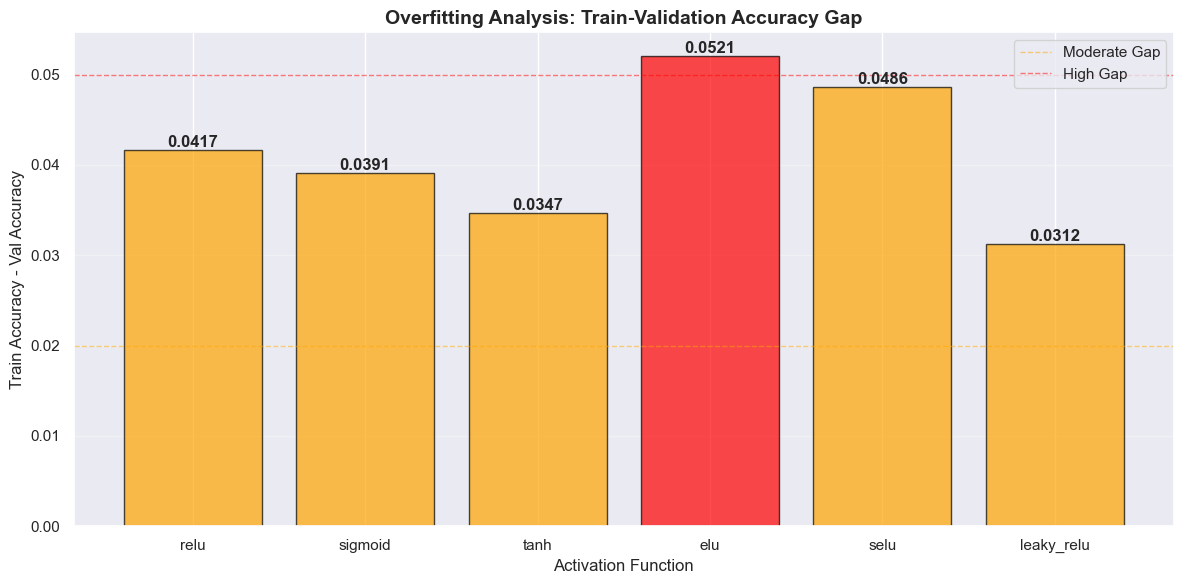


DETAILED ANALYSIS: SELU

Model Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,960 (222.50 KB)

 Trainable params: 18,986 (74.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,974 (148.34 KB)


Training Progression:
  Epoch 1  - Train Acc: 0.7163, Val Acc: 0.8785
  Epoch 10 - Train Acc: 1.0000, Val Acc: 0.9514
  Epoch 25 - Train Acc: 1.0000, Val Acc: 0.9514
  Epoch 50 - Train Acc: 1.0000, Val Acc: 0.9514

Final Performance:
  Test Accuracy: 0.9889
  Test Loss: 0.1807

ACTIVATION FUNCTION CHARACTERISTICS

Key Characteristics:

RELU:
  Fast, simple, prone to "dying ReLU" problem
  Test Accuracy: 0.9806

SIGMOID:
  Smooth, outputs [0,1], vanishing gradient issues
  Test Accuracy: 0.9667

TANH:
  Zero-centered, outputs [-1,1], better than sigmoid
  Test Accuracy: 0.9833

ELU:
  Smooth negative values, helps with vanishing gradients
  Test Accuracy: 0.9778

SELU:
  Self-normalizing, good for deep networks
  Test Accuracy: 0.9889

LEAKY_RELU:
  Prevents dying ReLU, allows small negative gradients
  Test Accuracy: 0.9778

RECOMMENDATIONS

For this digits classification task:
  Best choice: SELU
  Achieves 98.89% accuracy

General Guidelines:
  • ReLU: Default choice for most proble

In [17]:
# EXPERIMENT WITH DIFFERENT ACTIVATION FUNCTIONS (TensorFlow/Keras)
print("EXPERIMENTING WITH DIFFERENT ACTIVATION FUNCTIONS")
print("="*60)

# List of activation functions to test
activation_functions = ['relu', 'sigmoid', 'tanh', 'elu', 'selu', 'leaky_relu']

# Store results for comparison
activation_results = {}

print("\nTraining models with different activation functions...")
print("This may take a few minutes...\n")

# Train a model with each activation function
for activation in activation_functions:
    print(f"\n{'='*50}")
    print(f"Training with {activation.upper()} activation")
    print('='*50)
    
    # Build model with the current activation function
    model = keras.Sequential()
    
    if activation == 'leaky_relu':
        # LeakyReLU requires a special layer
        model.add(keras.layers.Dense(128, input_shape=(X_train_scaled.shape[1],)))
        model.add(keras.layers.LeakyReLU(alpha=0.01))
        model.add(keras.layers.Dense(64))
        model.add(keras.layers.LeakyReLU(alpha=0.01))
        model.add(keras.layers.Dense(32))
        model.add(keras.layers.LeakyReLU(alpha=0.01))
    else:
        # Standard activation functions
        model.add(keras.layers.Dense(128, activation=activation, input_shape=(X_train_scaled.shape[1],)))
        model.add(keras.layers.Dense(64, activation=activation))
        model.add(keras.layers.Dense(32, activation=activation))
    
    # Output layer uses softmax for multi-class classification
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0  # Silent training
    )
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    
    # Store results
    activation_results[activation] = {
        'model': model,
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'train_loss': history.history['loss'],
        'train_accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy'],
        'final_train_acc': history.history['accuracy'][-1],
        'final_val_acc': history.history['val_accuracy'][-1]
    }
    
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

# Summary comparison
print("\n" + "="*60)
print("ACTIVATION FUNCTION COMPARISON SUMMARY")
print("="*60)

# Create comparison DataFrame
comparison_data = {
    'Activation': [],
    'Train Acc': [],
    'Val Acc': [],
    'Test Acc': [],
    'Test Loss': [],
    'Overfit Gap': []
}

for activation in activation_functions:
    results = activation_results[activation]
    overfit_gap = results['final_train_acc'] - results['final_val_acc']
    
    comparison_data['Activation'].append(activation)
    comparison_data['Train Acc'].append(f"{results['final_train_acc']:.4f}")
    comparison_data['Val Acc'].append(f"{results['final_val_acc']:.4f}")
    comparison_data['Test Acc'].append(f"{results['test_accuracy']:.4f}")
    comparison_data['Test Loss'].append(f"{results['test_loss']:.4f}")
    comparison_data['Overfit Gap'].append(f"{overfit_gap:.4f}")

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))

# Find best performing activation
best_activation = max(activation_results.items(), 
                     key=lambda x: x[1]['test_accuracy'])
worst_activation = min(activation_results.items(), 
                      key=lambda x: x[1]['test_accuracy'])

print(f"\nBest Activation: {best_activation[0].upper()}")
print(f"  Test Accuracy: {best_activation[1]['test_accuracy']:.4f}")
print(f"  Test Loss: {best_activation[1]['test_loss']:.4f}")

print(f"\nWorst Activation: {worst_activation[0].upper()}")
print(f"  Test Accuracy: {worst_activation[1]['test_accuracy']:.4f}")
print(f"  Test Loss: {worst_activation[1]['test_loss']:.4f}")

# Visualization 1: Training curves comparison
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, activation in enumerate(activation_functions):
    results = activation_results[activation]
    
    axes[idx].plot(results['train_accuracy'], label='Train Acc', linewidth=2)
    axes[idx].plot(results['val_accuracy'], label='Val Acc', linewidth=2)
    axes[idx].set_title(f'{activation.upper()} - Accuracy Over Epochs', fontweight='bold')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Add final test accuracy as annotation
    axes[idx].text(0.02, 0.02, f"Test: {results['test_accuracy']:.4f}", 
                  transform=axes[idx].transAxes,
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Visualization 2: Loss curves comparison
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, activation in enumerate(activation_functions):
    results = activation_results[activation]
    
    axes[idx].plot(results['train_loss'], label='Train Loss', linewidth=2)
    axes[idx].plot(results['val_loss'], label='Val Loss', linewidth=2)
    axes[idx].set_title(f'{activation.upper()} - Loss Over Epochs', fontweight='bold')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization 3: Bar chart comparison of test accuracies
fig, ax = plt.subplots(figsize=(12, 6))

activations = list(activation_results.keys())
test_accs = [activation_results[act]['test_accuracy'] for act in activations]
colors_bar = ['green' if acc == max(test_accs) else 'lightcoral' if acc == min(test_accs) else 'skyblue' 
              for acc in test_accs]

bars = ax.bar(activations, test_accs, color=colors_bar, alpha=0.7, edgecolor='black')
ax.set_title('Test Accuracy by Activation Function', fontsize=14, fontweight='bold')
ax.set_xlabel('Activation Function', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_ylim([min(test_accs) - 0.05, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Visualization 4: Overfitting analysis
fig, ax = plt.subplots(figsize=(12, 6))

overfit_gaps = [activation_results[act]['final_train_acc'] - 
                activation_results[act]['final_val_acc'] 
                for act in activations]
colors_gap = ['red' if gap > 0.05 else 'orange' if gap > 0.02 else 'green' 
              for gap in overfit_gaps]

bars = ax.bar(activations, overfit_gaps, color=colors_gap, alpha=0.7, edgecolor='black')
ax.set_title('Overfitting Analysis: Train-Validation Accuracy Gap', fontsize=14, fontweight='bold')
ax.set_xlabel('Activation Function', fontsize=12)
ax.set_ylabel('Train Accuracy - Val Accuracy', fontsize=12)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=0.02, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Moderate Gap')
ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High Gap')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed analysis of best activation
print("\n" + "="*60)
print(f"DETAILED ANALYSIS: {best_activation[0].upper()}")
print("="*60)

best_model = best_activation[1]['model']
best_history = best_activation[1]['history']

print(f"\nModel Architecture:")
best_model.summary()

print(f"\nTraining Progression:")
print(f"  Epoch 1  - Train Acc: {best_history.history['accuracy'][0]:.4f}, Val Acc: {best_history.history['val_accuracy'][0]:.4f}")
print(f"  Epoch 10 - Train Acc: {best_history.history['accuracy'][9]:.4f}, Val Acc: {best_history.history['val_accuracy'][9]:.4f}")
print(f"  Epoch 25 - Train Acc: {best_history.history['accuracy'][24]:.4f}, Val Acc: {best_history.history['val_accuracy'][24]:.4f}")
print(f"  Epoch 50 - Train Acc: {best_history.history['accuracy'][-1]:.4f}, Val Acc: {best_history.history['val_accuracy'][-1]:.4f}")

print(f"\nFinal Performance:")
print(f"  Test Accuracy: {best_activation[1]['test_accuracy']:.4f}")
print(f"  Test Loss: {best_activation[1]['test_loss']:.4f}")

# Activation function characteristics
print("\n" + "="*60)
print("ACTIVATION FUNCTION CHARACTERISTICS")
print("="*60)

characteristics = {
    'relu': 'Fast, simple, prone to "dying ReLU" problem',
    'sigmoid': 'Smooth, outputs [0,1], vanishing gradient issues',
    'tanh': 'Zero-centered, outputs [-1,1], better than sigmoid',
    'elu': 'Smooth negative values, helps with vanishing gradients',
    'selu': 'Self-normalizing, good for deep networks',
    'leaky_relu': 'Prevents dying ReLU, allows small negative gradients'
}

print("\nKey Characteristics:")
for activation in activation_functions:
    print(f"\n{activation.upper()}:")
    print(f"  {characteristics[activation]}")
    print(f"  Test Accuracy: {activation_results[activation]['test_accuracy']:.4f}")

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)

print(f"\nFor this digits classification task:")
print(f"  Best choice: {best_activation[0].upper()}")
print(f"  Achieves {best_activation[1]['test_accuracy']:.2%} accuracy")

print(f"\nGeneral Guidelines:")
print(f"  • ReLU: Default choice for most problems (fast, simple)")
print(f"  • LeakyReLU: When concerned about dying neurons")
print(f"  • ELU/SELU: For very deep networks or when smoothness matters")
print(f"  • Tanh: When you need zero-centered outputs")
print(f"  • Sigmoid: Mainly for output layer in binary classification")
